# Analysis of the world market

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("Demographic.csv")
df.head()

Country Name Country Code                   Series Name     Series Code  \
0  Afghanistan          AFG             Population, total     SP.POP.TOTL   
1  Afghanistan          AFG  GDP per capita (current US$)  NY.GDP.PCAP.CD   
2      Albania          ALB             Population, total     SP.POP.TOTL   
3      Albania          ALB  GDP per capita (current US$)  NY.GDP.PCAP.CD   
4      Algeria          DZA             Population, total     SP.POP.TOTL   

      2020 [YR2020]     2021 [YR2021]     2022 [YR2022]     2023 [YR2023]  \
0          39068979          40000412          40578842          41454761   
1  510.787063366811  356.496214115892  357.261152798144  413.757894705303   
2           2837849           2811666           2777689           2745972   
3  5370.77749956875  6413.28280828537  6846.42669381643  8575.17134637222   
4          44042091          44761099          45477389          46164219   

      2024 [YR2024]  
0          42647492  
1                ..  
2           2714617  
3  10011.6279856667  
4          46814308

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   534 non-null    object
 1   Country Code   532 non-null    object
 2   Series Name    532 non-null    object
 3   Series Code    532 non-null    object
 4   2020 [YR2020]  532 non-null    object
 5   2021 [YR2021]  532 non-null    object
 6   2022 [YR2022]  532 non-null    object
 7   2023 [YR2023]  532 non-null    object
 8   2024 [YR2024]  532 non-null    object
dtypes: object(9)
memory usage: 37.9+ KB


## Cleaning

In [ ]:
#Rename the columns
df.columns = ['Country_Name', 'Country_Code', 'Series_Name', 'Series_Code', '2020', '2021', '2022', '2023', '2024']

df_clean = df.dropna(subset=['Country_Code'])

# Restructure: Go from 'wide' to 'long'
years = ['2020', '2021', '2022', '2023', '2024']
df_long = df_clean.melt(
    id_vars=['Country_Name', 'Country_Code', 'Series_Name'],
    value_vars=years,
    var_name='Year',
    value_name='Value'
)

#Add, delete and convert value column
df_long['Value'] = df_long['Value'].replace({'..': np.nan})
df_long['Value'] = pd.to_numeric(df_long['Value'])
df_long['Value'] = df_long['Value'].astype(str).str.replace(',', '', regex=False).str.strip()

# **Forced conversion:** Attempt to convert to float. If it finds *any* error, it converts it to NaN.
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')
df_final = df_long.dropna(subset=['Value'])



# Pivot to have Indicators as columns and Country/Year as rows
df_pivot = df_final.pivot_table(
    index=['Country_Name', 'Country_Code', 'Year'],
    columns='Series_Name',
    values='Value'
).reset_index()


#Rename indicator columns for clarity
df_pivot.rename(columns={
    'Population, total': 'Population',
    'GDP per capita (current US$)': 'GDP_per_capita'
}, inplace=True)


# 1. KEYWORD LIST (Syntax and keywords corrected!)
aggregate_keywords = [
    'income', 'total', 'blend', 'IDA', 'IBRD', 'World', 'Africa', 'Asia',
    'Latin America', 'Caribbean', 'Sub-Saharan', 'Middle East', 'OECD members',
    'Least developed', 'Fragile', 'small states', 'European Union', 'Euro area',
    'Pacific island', 'North America', 'Central Asia', 'Heavily indebted',
    'Post-demographic', 'Early-demographic', 'Late-demographic', 'Other small states',
    'Pre-demographic dividend', 'Central Europe and the Baltics', 'Islamic Rep.'

]

# 2. Build the Regular Expression for the Filter
# The .join() function builds an expression like 'word1|word2|word3'
regex_pattern = '|'.join(aggregate_keywords)

# 3. Apply FILTERING
# Use regex=True for the vertical bar (OR) and case=False to ignore case.
# VERY IMPORTANT: Use the correct column name (check your df_pivot if it's 'Country Name' or 'Country_Name')
is_aggregate = df_pivot['Country_Name'].str.contains(
    regex_pattern,
    case=False,
    regex=True,
    na=False
)

# 4. Create the Clean DataFrame
df_pivot_countries = df_pivot[~is_aggregate].copy()

print(f"Filtering completed.")

Filtering completed.


## 2020

Calculating hierarchical clustering for the year 2020 with 205 countries...


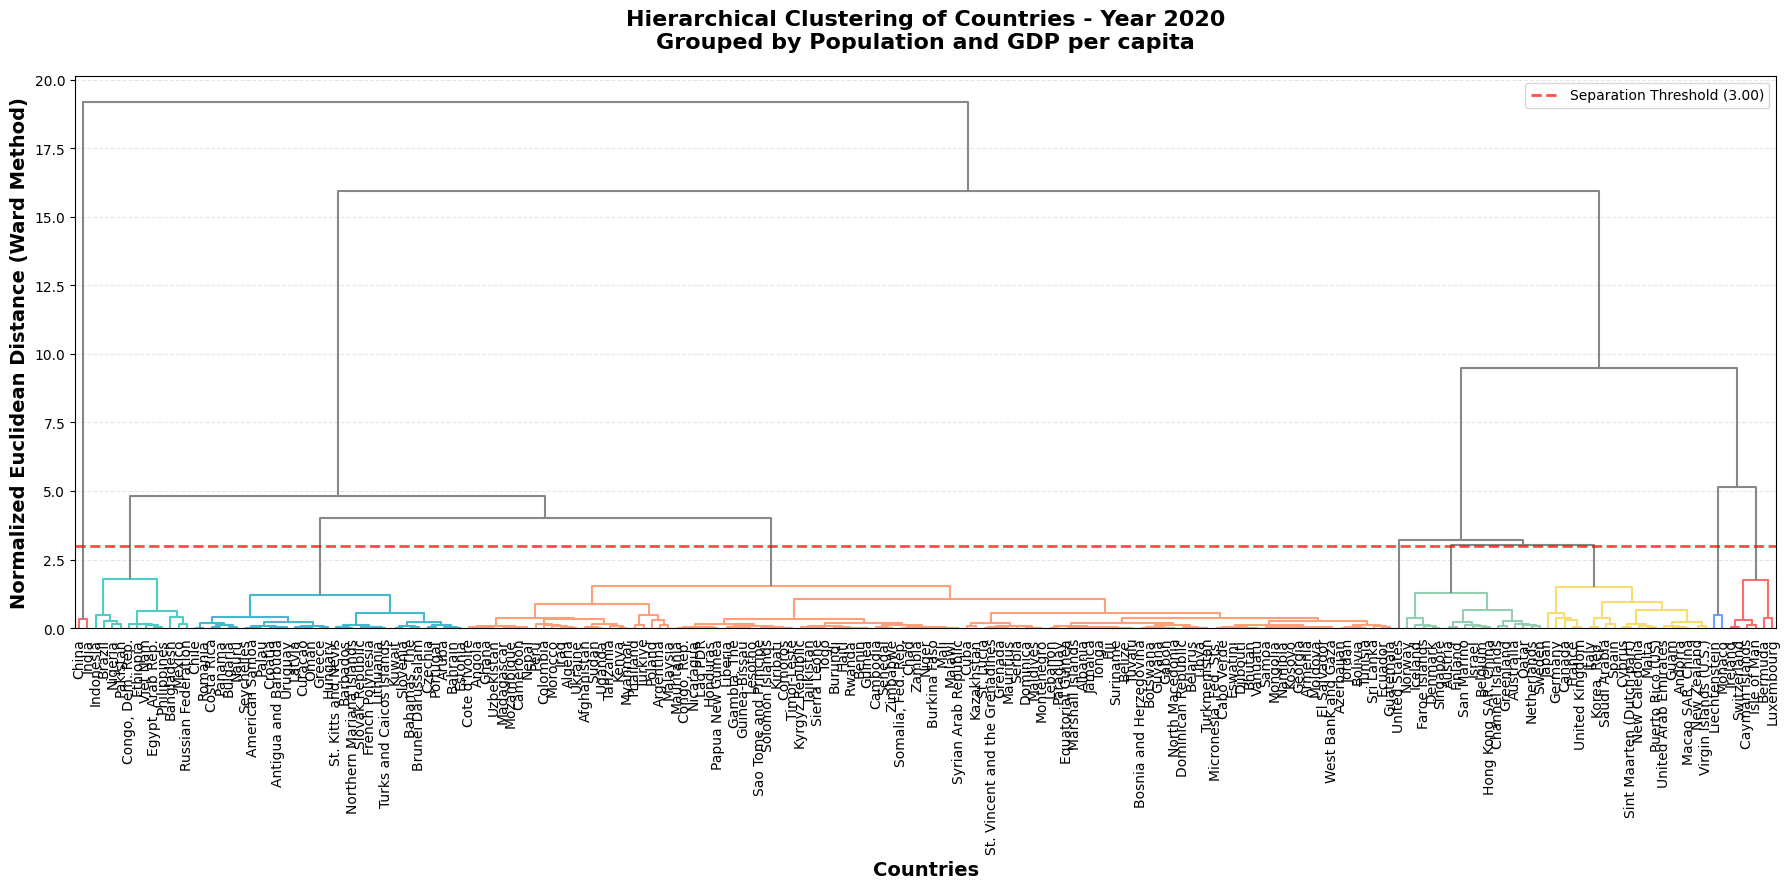

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2020.
With a Distance Threshold of 3.00, 9 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (12 countries): Congo, Dem. Rep., Bangladesh, Ethiopia, Egypt, Arab Rep., Indonesia, Brazil, Mexico, Russian Federation, Nigeria, Viet Nam, Philippines, Pakistan
Cluster 3 (33 countries): Curacao, Bulgaria, Chile, Costa Rica, Estonia, Czechia, French Polynesia, Bahamas, The, Barbados, Kuwait, Greece, Latvia, Lithuania, Croatia, Bahrain, Brunei Darussalam, Aruba, American Samoa, Northern Mariana Islands, Slovak Republic, St. Kitts and Nevis, Slovenia, Turks and

In [ ]:


Target_Year = '2020'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year = df_pivot_countries[df_pivot_countries['Year'] == Target_Year].copy()

df_year.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year)} countries...")


# Prepare data
features_for_clustering = df_year[['Population', 'GDP_per_capita']].values
country_names = df_year['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering of Countries - Year {Target_Year}\nGrouped by Population and GDP per capita',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year['Cluster'] = clusters
df_year.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year.loc[df_year['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

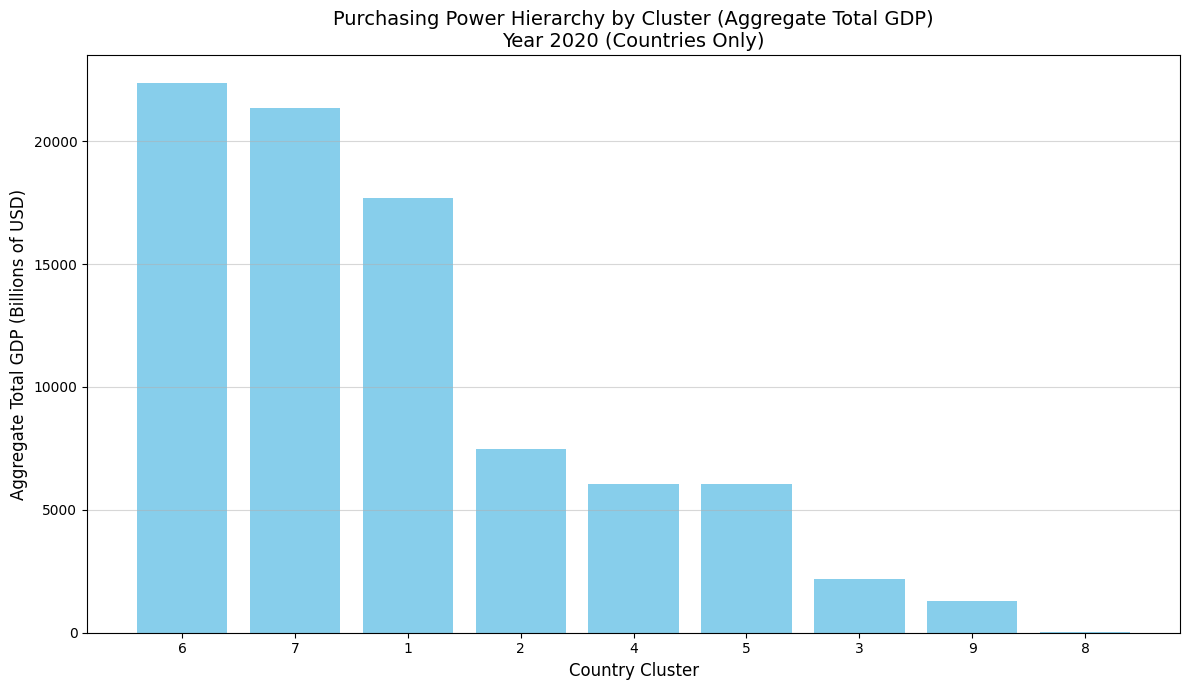

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

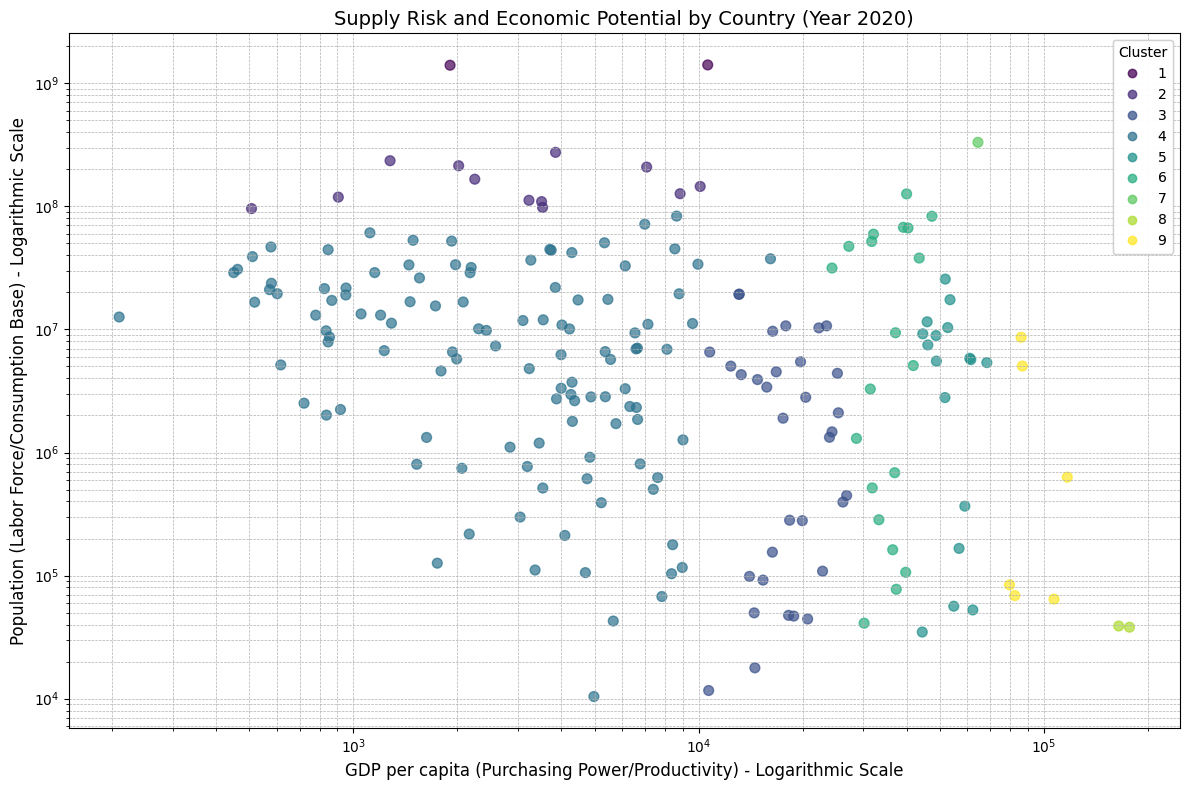

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2021

Calculating hierarchical clustering for the year 2021 with 205 countries...


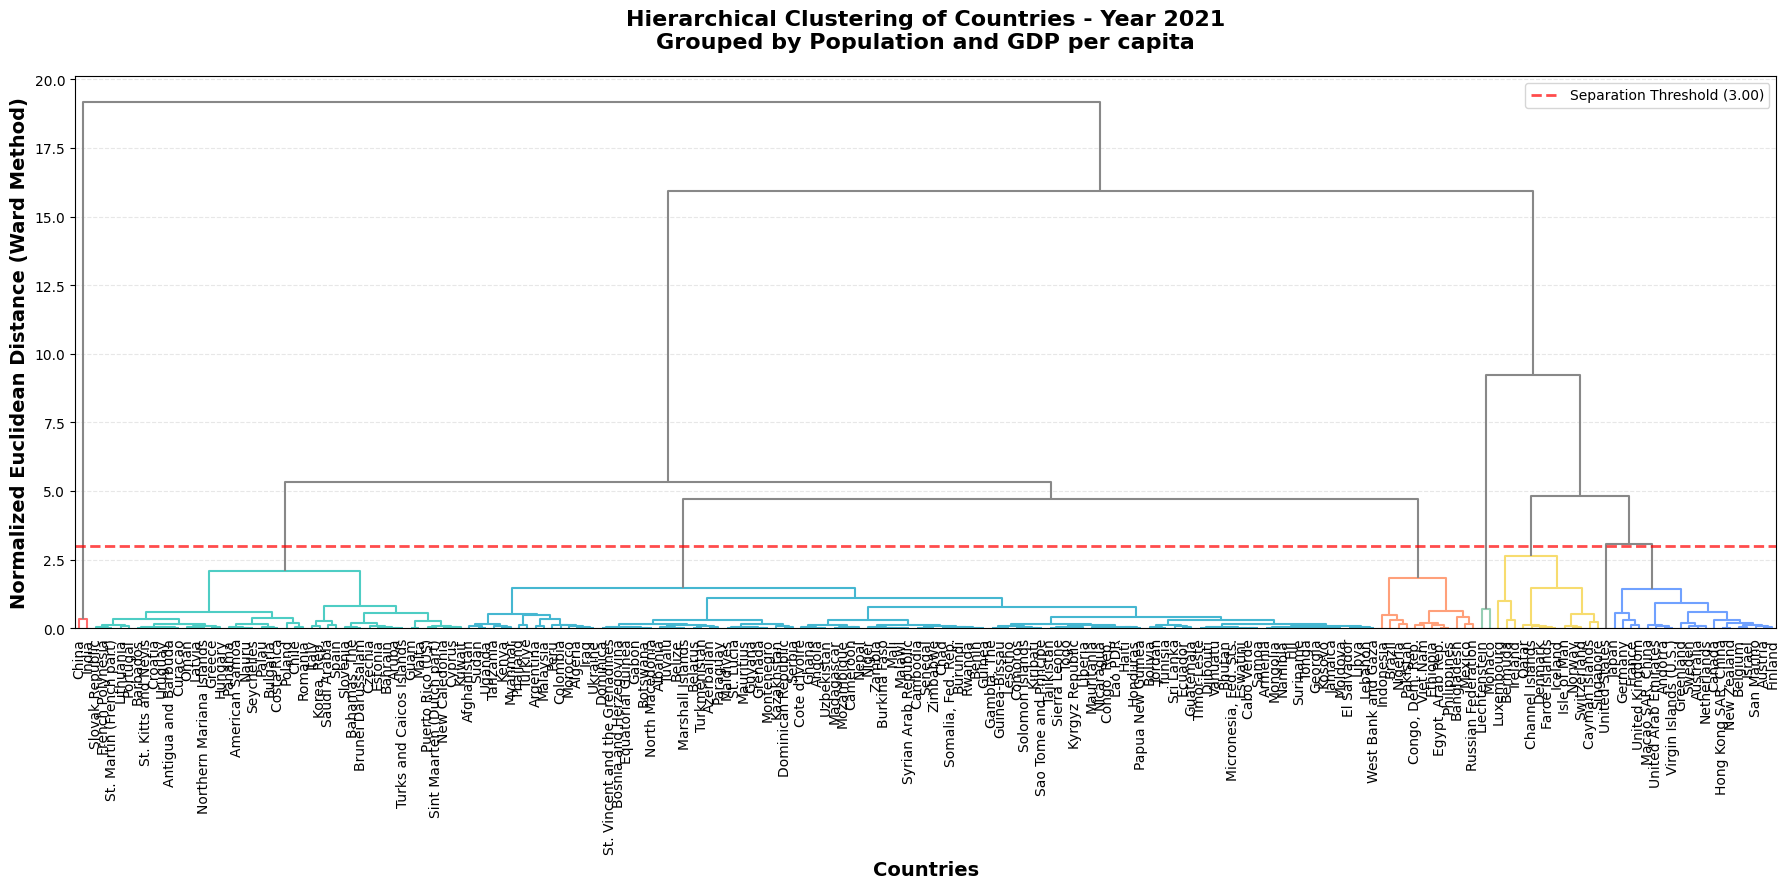

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2021.
With a Distance Threshold of 3.00, 8 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (45 countries): Bahamas, The, American Samoa, Bahrain, Bulgaria, Brunei Darussalam, Antigua and Barbuda, Cyprus, Czechia, Estonia, Costa Rica, Croatia, Curacao, Chile, Aruba, Korea, Rep., Kuwait, Italy, Hungary, Greece, Malta, Latvia, Lithuania, French Polynesia, Guam, Barbados, Palau, Northern Mariana Islands, Oman, New Caledonia, Nauru, Seychelles, Slovenia, Slovak Republic, Sint Maarten (Dutch part), St. Kitts and Nevis, Romania, Saudi Arabia, Poland, Panam

In [ ]:


Target_Year = '2021'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year = df_pivot_countries[df_pivot_countries['Year'] == Target_Year].copy()

df_year.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year)} countries...")


# Prepare data
features_for_clustering = df_year[['Population', 'GDP_per_capita']].values
country_names = df_year['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering of Countries - Year {Target_Year}\nGrouped by Population and GDP per capita',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year['Cluster'] = clusters
df_year.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year.loc[df_year['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

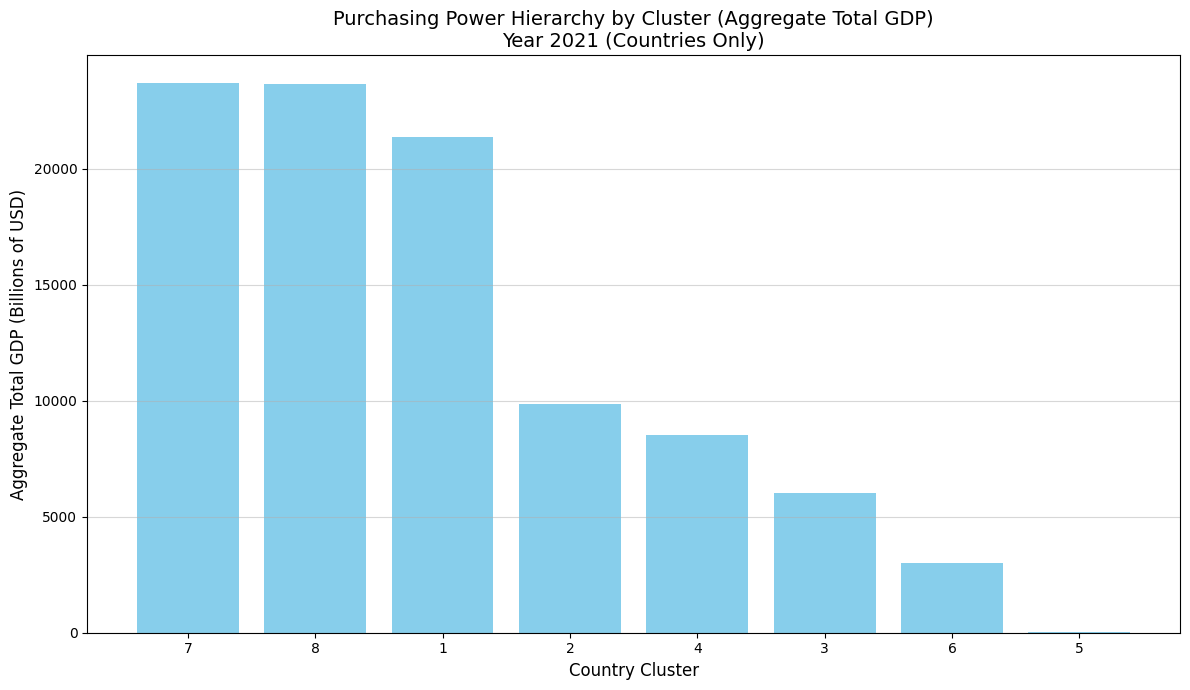

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

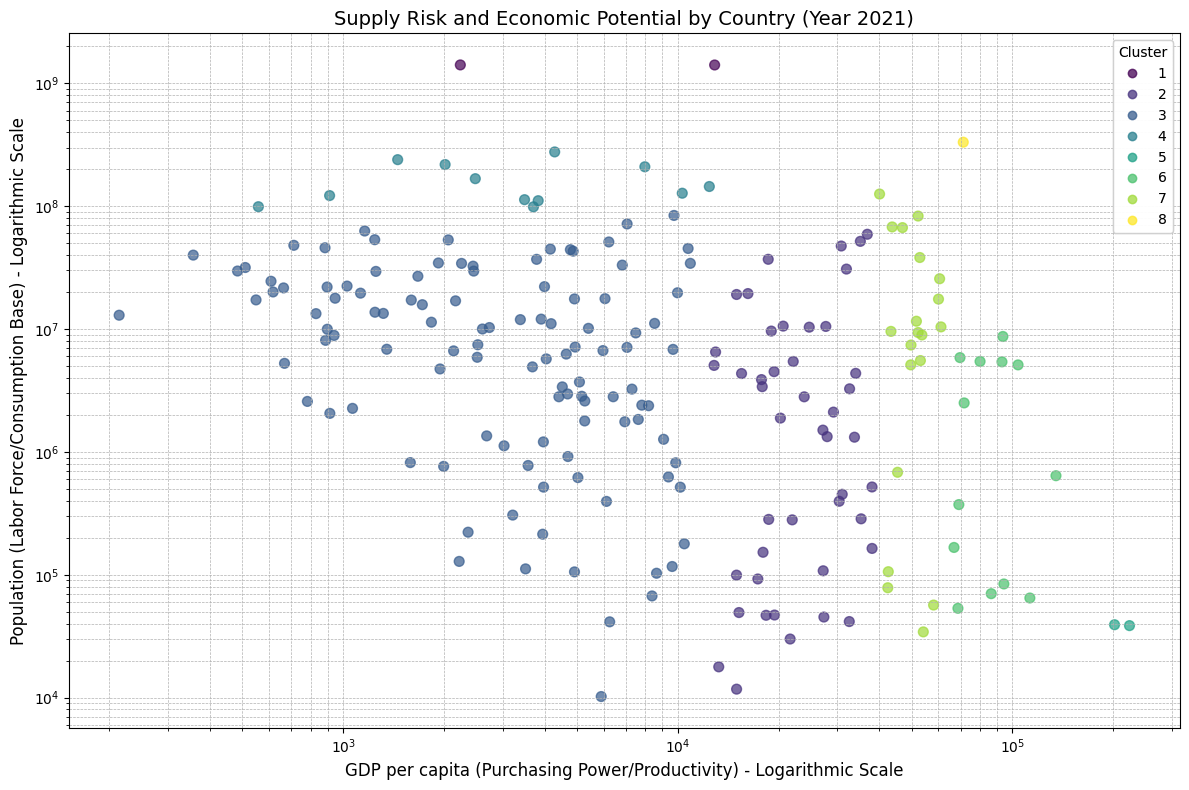

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2022

Calculating hierarchical clustering for the year 2022 with 204 countries...


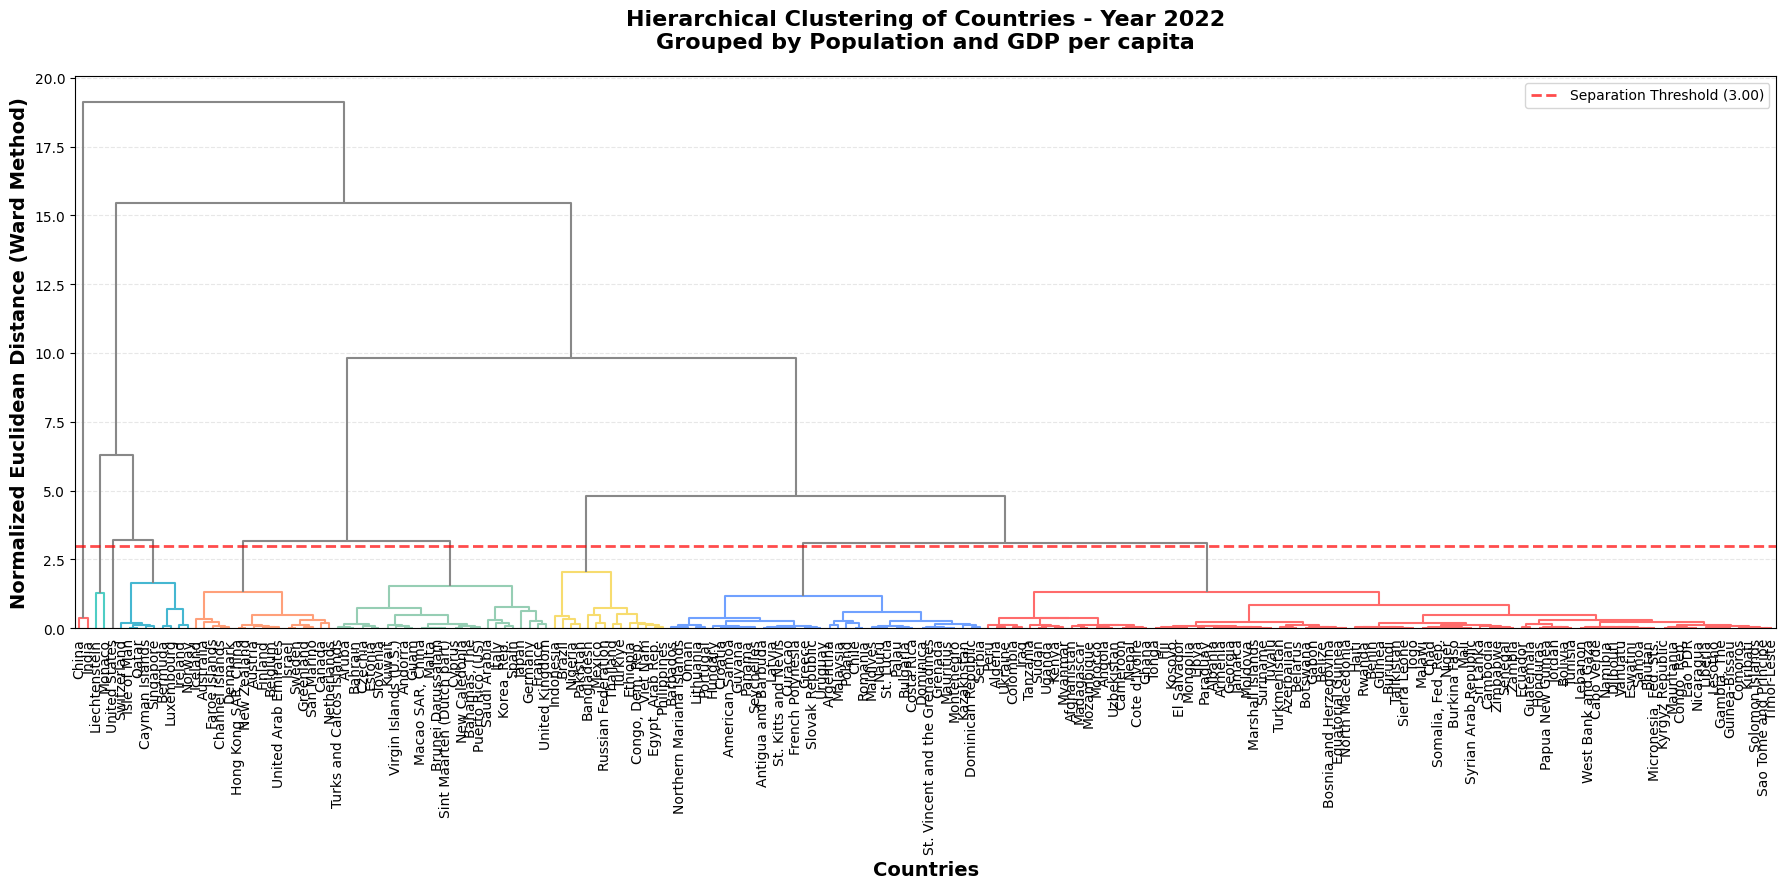

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2022.
With a Distance Threshold of 3.00, 9 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (2 countries): Liechtenstein, Monaco
Cluster 3 (9 countries): Ireland, Bermuda, Cayman Islands, Isle of Man, Luxembourg, Switzerland, Qatar, Norway, Singapore
Cluster 4 (1 countries): United States
Cluster 5 (17 countries): Faroe Islands, Denmark, Greenland, Hong Kong SAR, China, Finland, Iceland, Israel, Channel Islands, New Zealand, United Arab Emirates, Sweden, Netherlands, San Marino, Australia, Canada, Austria, Belgium
Cluster 6 (26 countries): Italy, Fra

In [ ]:


Target_Year = '2022'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year = df_pivot_countries[df_pivot_countries['Year'] == Target_Year].copy()

df_year.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year)} countries...")


# Prepare data
features_for_clustering = df_year[['Population', 'GDP_per_capita']].values
country_names = df_year['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering of Countries - Year {Target_Year}\nGrouped by Population and GDP per capita',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year['Cluster'] = clusters
df_year.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year.loc[df_year['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

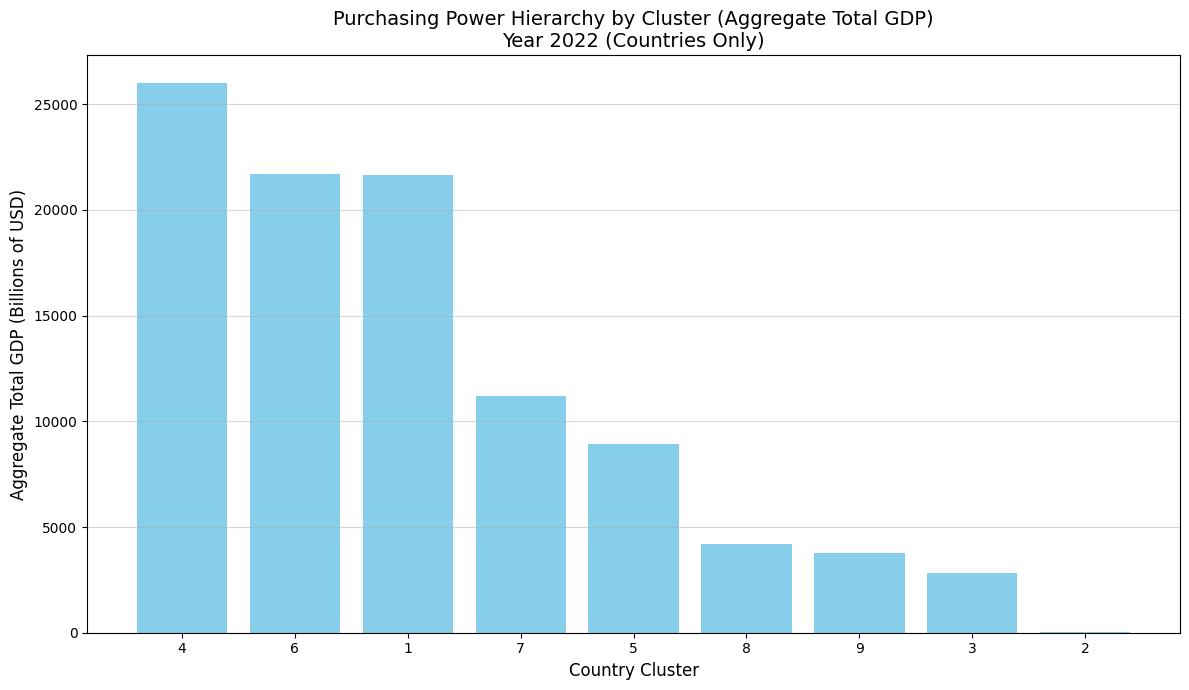

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

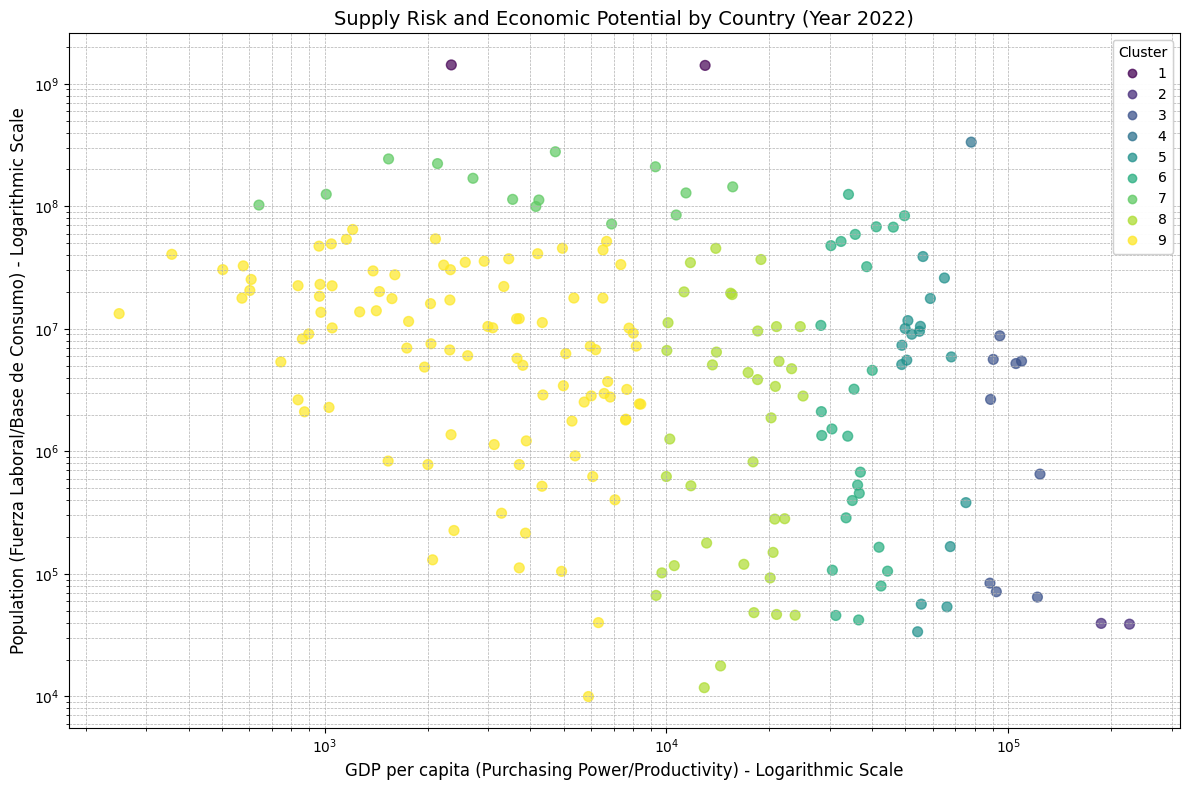

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Fuerza Laboral/Base de Consumo) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2023

Calculating hierarchical clustering for the year 2023 with 196 countries...


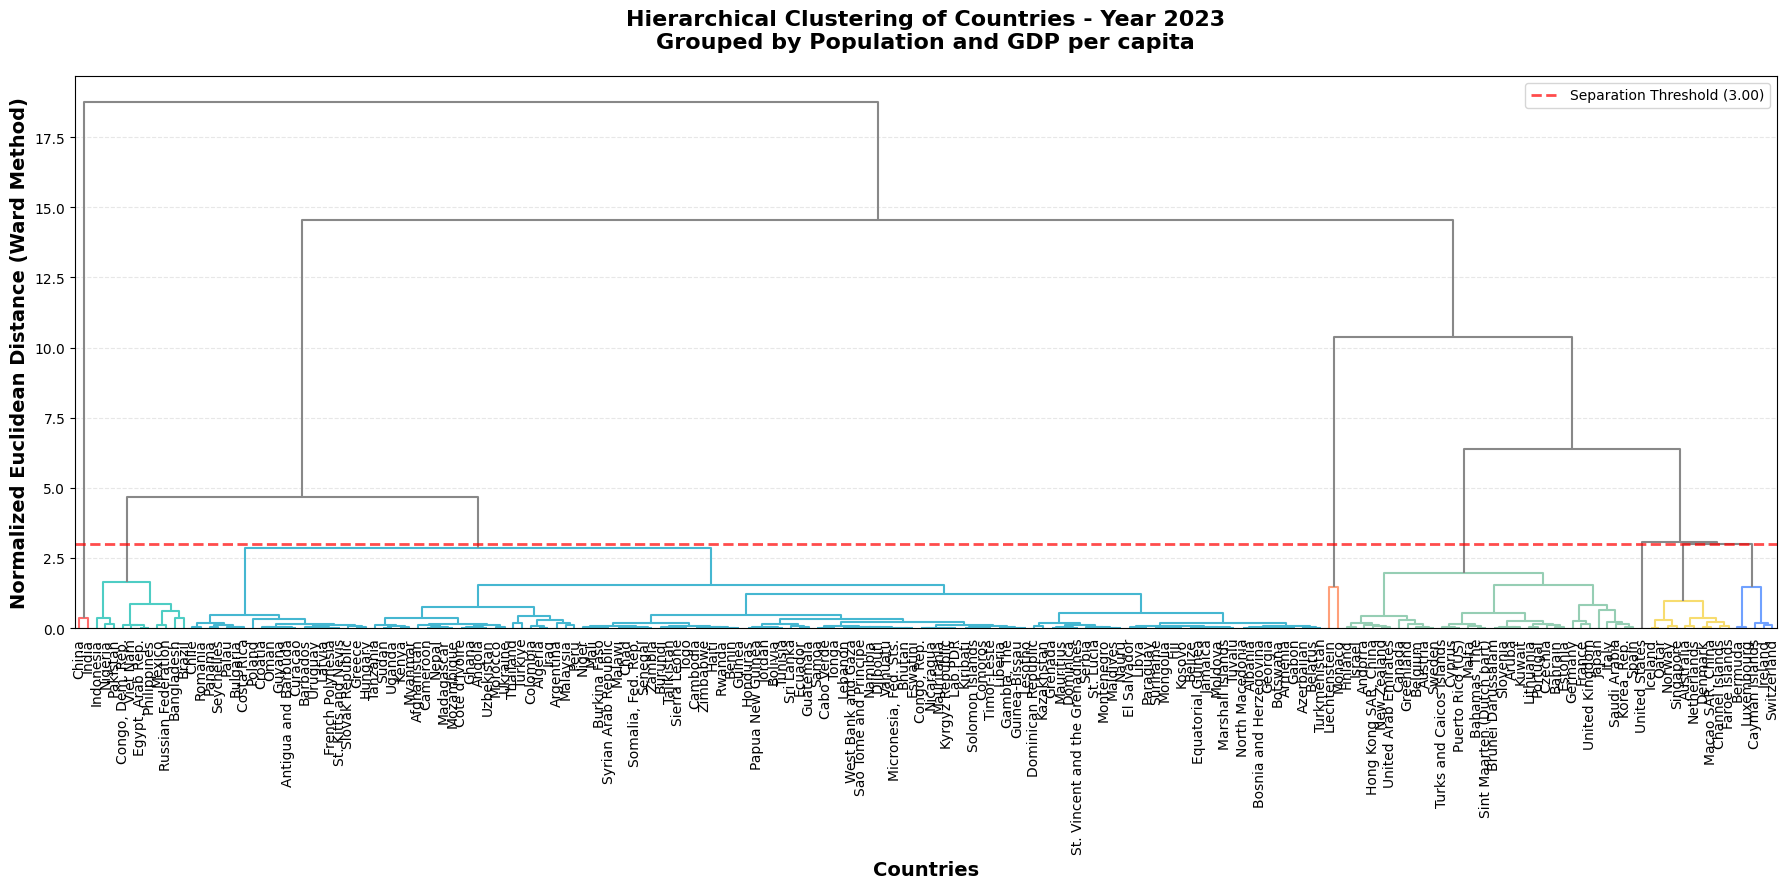

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2023.
With a Distance Threshold of 3.00, 8 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (11 countries): Congo, Dem. Rep., Bangladesh, Egypt, Arab Rep., Mexico, Indonesia, Brazil, Russian Federation, Philippines, Pakistan, Viet Nam, Nigeria
Cluster 3 (131 countries): Barbados, Bolivia, Azerbaijan, Cabo Verde, Burundi, Bulgaria, Burkina Faso, Cambodia, Bhutan, Botswana, Cote d'Ivoire, Cameroon, Comoros, Congo, Rep., Bosnia and Herzegovina, Belize, Argentina, Algeria, Afghanistan, French Polynesia, Fiji, Eswatini, Equatorial Guinea, Ecuador, El Salv

In [ ]:


Target_Year = '2023'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year = df_pivot_countries[df_pivot_countries['Year'] == Target_Year].copy()

df_year.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year)} countries...")


# Prepare data
features_for_clustering = df_year[['Population', 'GDP_per_capita']].values
country_names = df_year['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering of Countries - Year {Target_Year}\nGrouped by Population and GDP per capita',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year['Cluster'] = clusters
df_year.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year.loc[df_year['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

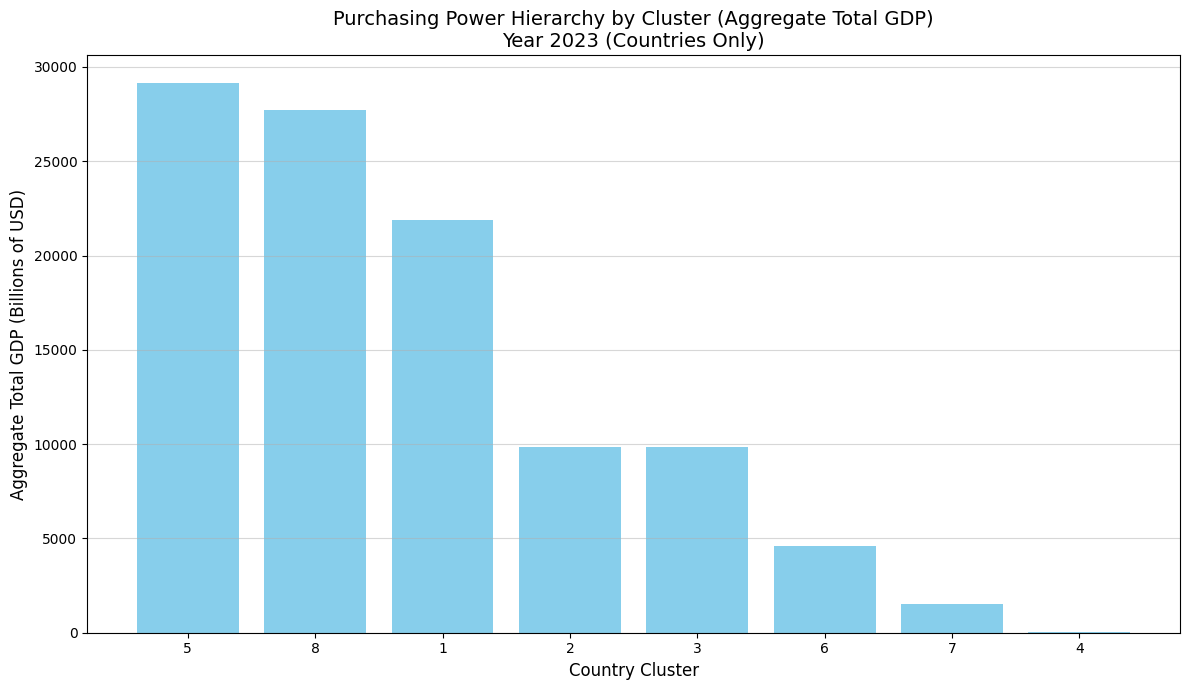

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

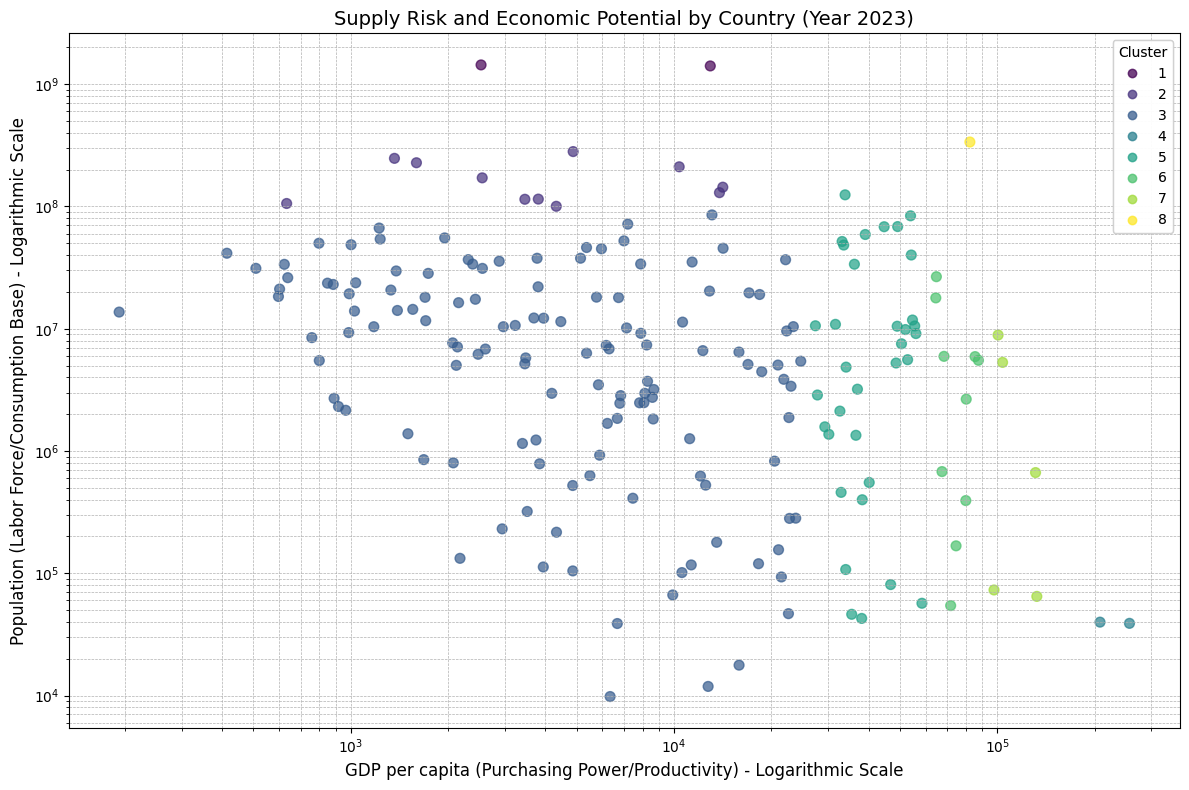

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2024

Calculating hierarchical clustering for the year 2024 with 179 countries...


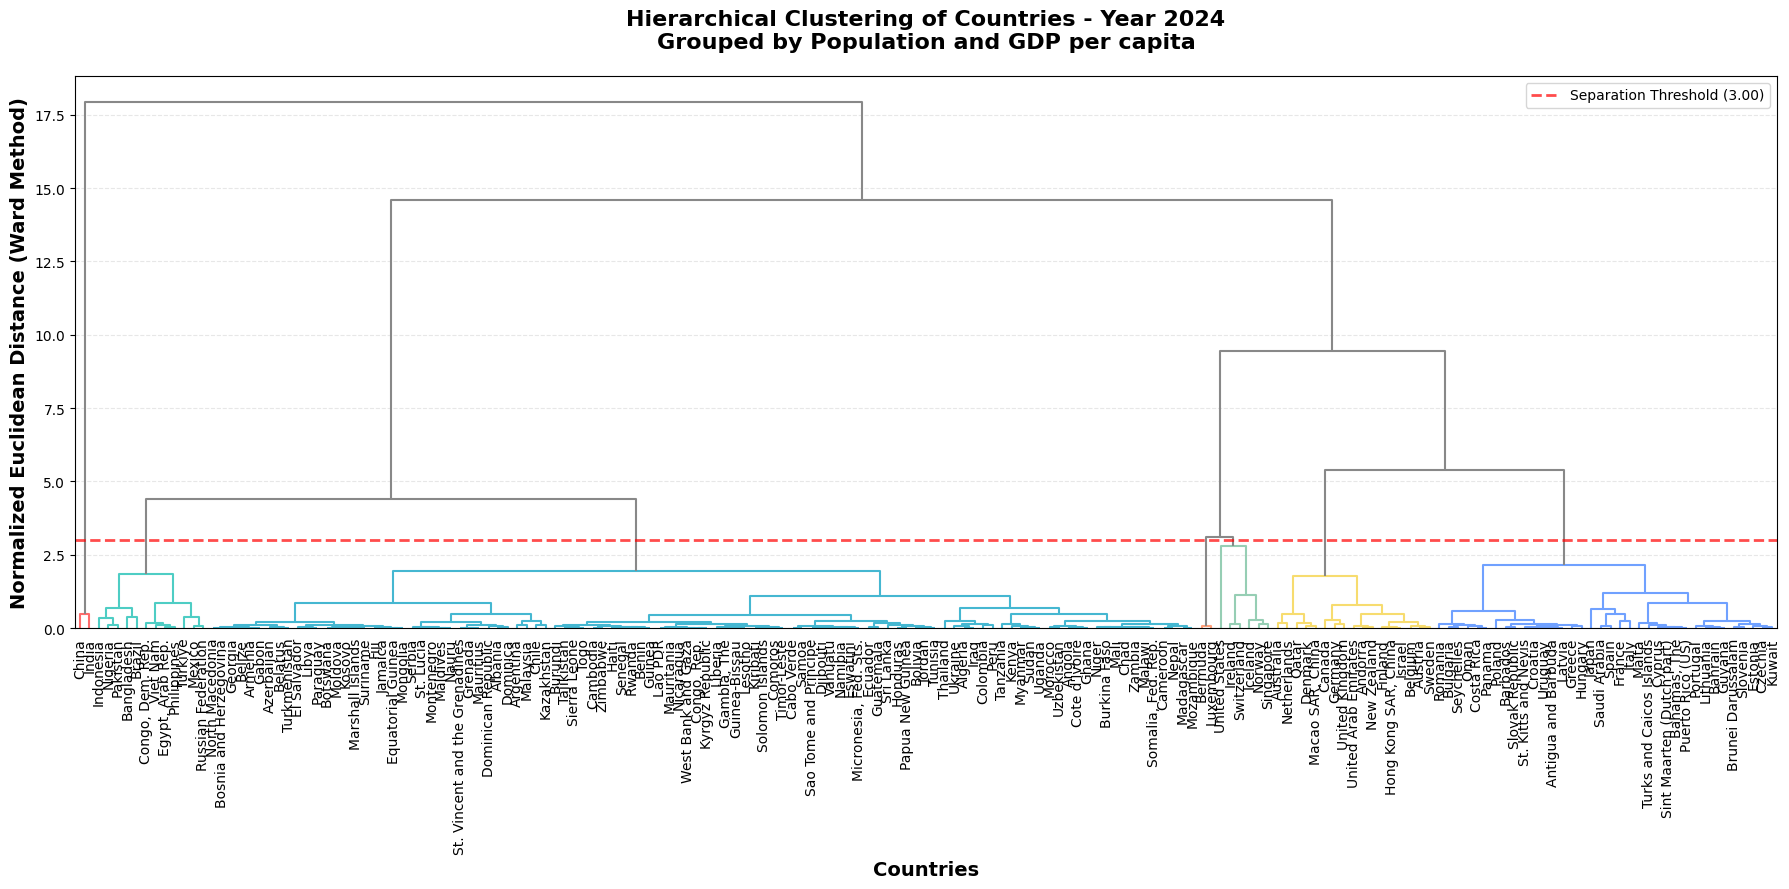

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2024.
With a Distance Threshold of 3.00, 7 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (12 countries): Congo, Dem. Rep., Bangladesh, Egypt, Arab Rep., Nigeria, Indonesia, Brazil, Mexico, Pakistan, Russian Federation, Philippines, Turkiye, Viet Nam
Cluster 3 (104 countries): Bosnia and Herzegovina, Burundi, Chad, Cameroon, Cabo Verde, Cambodia, Fiji, Djibouti, Dominican Republic, Dominica, Chile, Cote d'Ivoire, Congo, Rep., Botswana, Burkina Faso, Armenia, Angola, Albania, Guatemala, Grenada, Ghana, Gabon, Gambia, The, Georgia, El Salvador, Ecuad

In [ ]:


Target_Year = '2024'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year = df_pivot_countries[df_pivot_countries['Year'] == Target_Year].copy()

df_year.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year)} countries...")


# Prepare data
features_for_clustering = df_year[['Population', 'GDP_per_capita']].values
country_names = df_year['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering of Countries - Year {Target_Year}\nGrouped by Population and GDP per capita',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year['Cluster'] = clusters
df_year.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year.loc[df_year['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

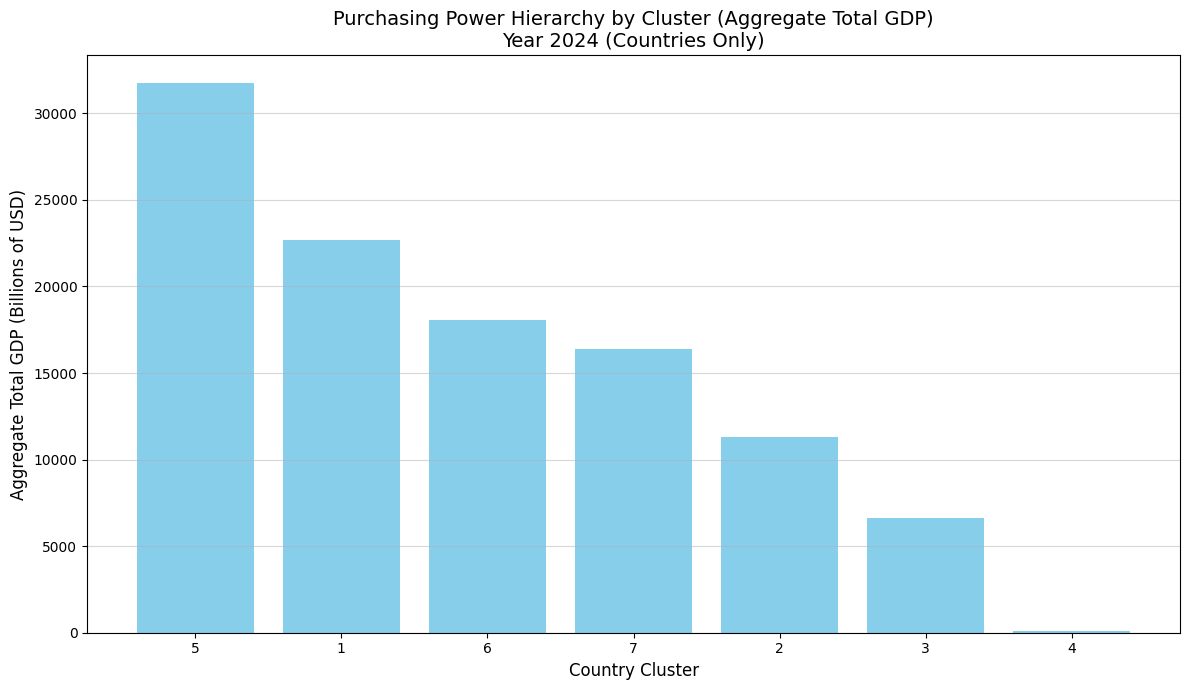

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

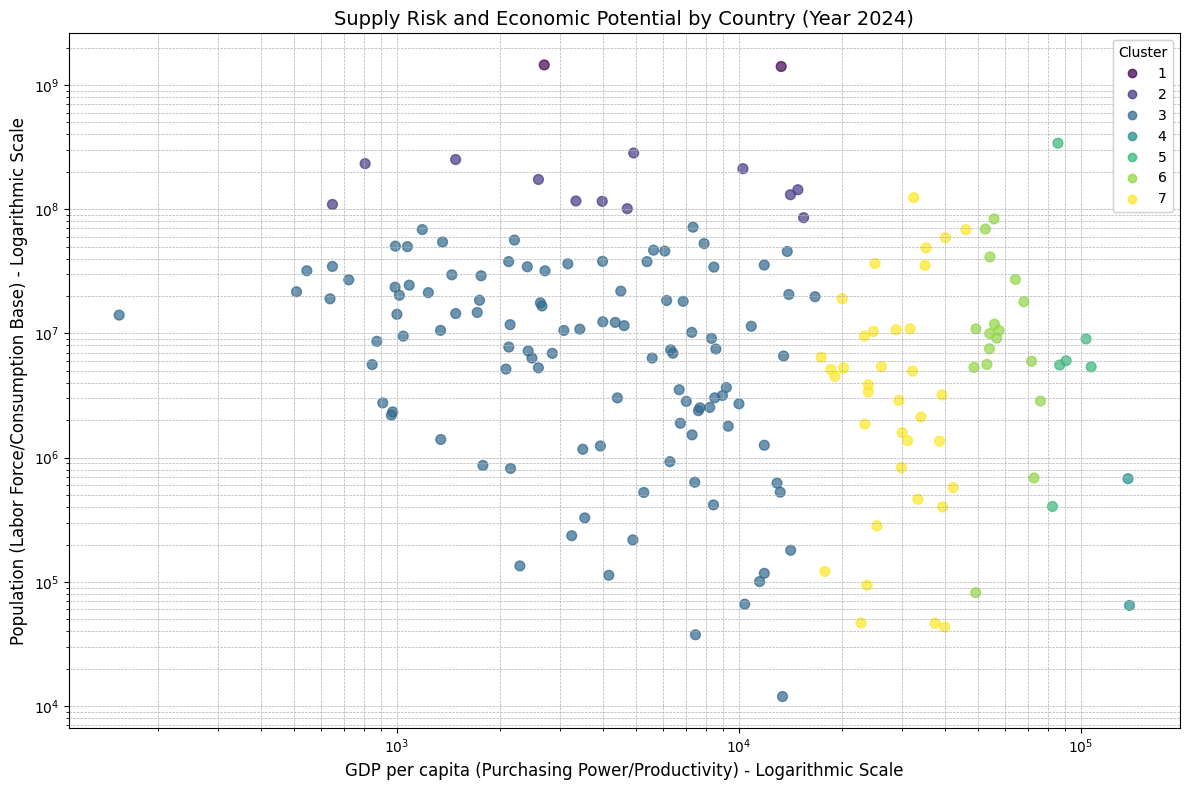

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

# American and Asia market

In [ ]:
# Install this library to know what continent belongs the country.
!pip install pycountry-convert

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import pycountry_convert as pc
from functools import lru_cache


@lru_cache(maxsize=None)
def robust_country_to_continent(country_code_iso3):
    """Converts ISO-3 country code to continent name."""
    if country_code_iso3 == 'XKX': return 'Europe'
    if country_code_iso3 == 'HKG': return 'Asia'
    if country_code_iso3 == 'MAC': return 'Asia'
    try:
        country_alpha2 = pc.country_alpha3_to_country_alpha2(country_code_iso3)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        return pc.convert_continent_code_to_continent_name(continent_code)
    except:
        return np.nan

# Apply the function to the 'Country_Code' column
df_pivot_countries['Continent'] = df_pivot_countries['Country_Code'].apply(robust_country_to_continent)

# Filter by America and Asia only (Names from pycountry-convert library)
target_continents = ['North America', 'South America', 'Asia']
df_america_asia = df_pivot_countries[
    df_pivot_countries['Continent'].isin(target_continents)
].copy()
df_america_asia.dropna(subset=['Continent'], inplace=True)

print(f"Unique countries from America and Asia found: {df_america_asia['Country_Name'].nunique()} countries.")

Unique countries from America and Asia found: 92 countries.


## 2020

Calculating hierarchical clustering for the year 2020 with 87 countries...


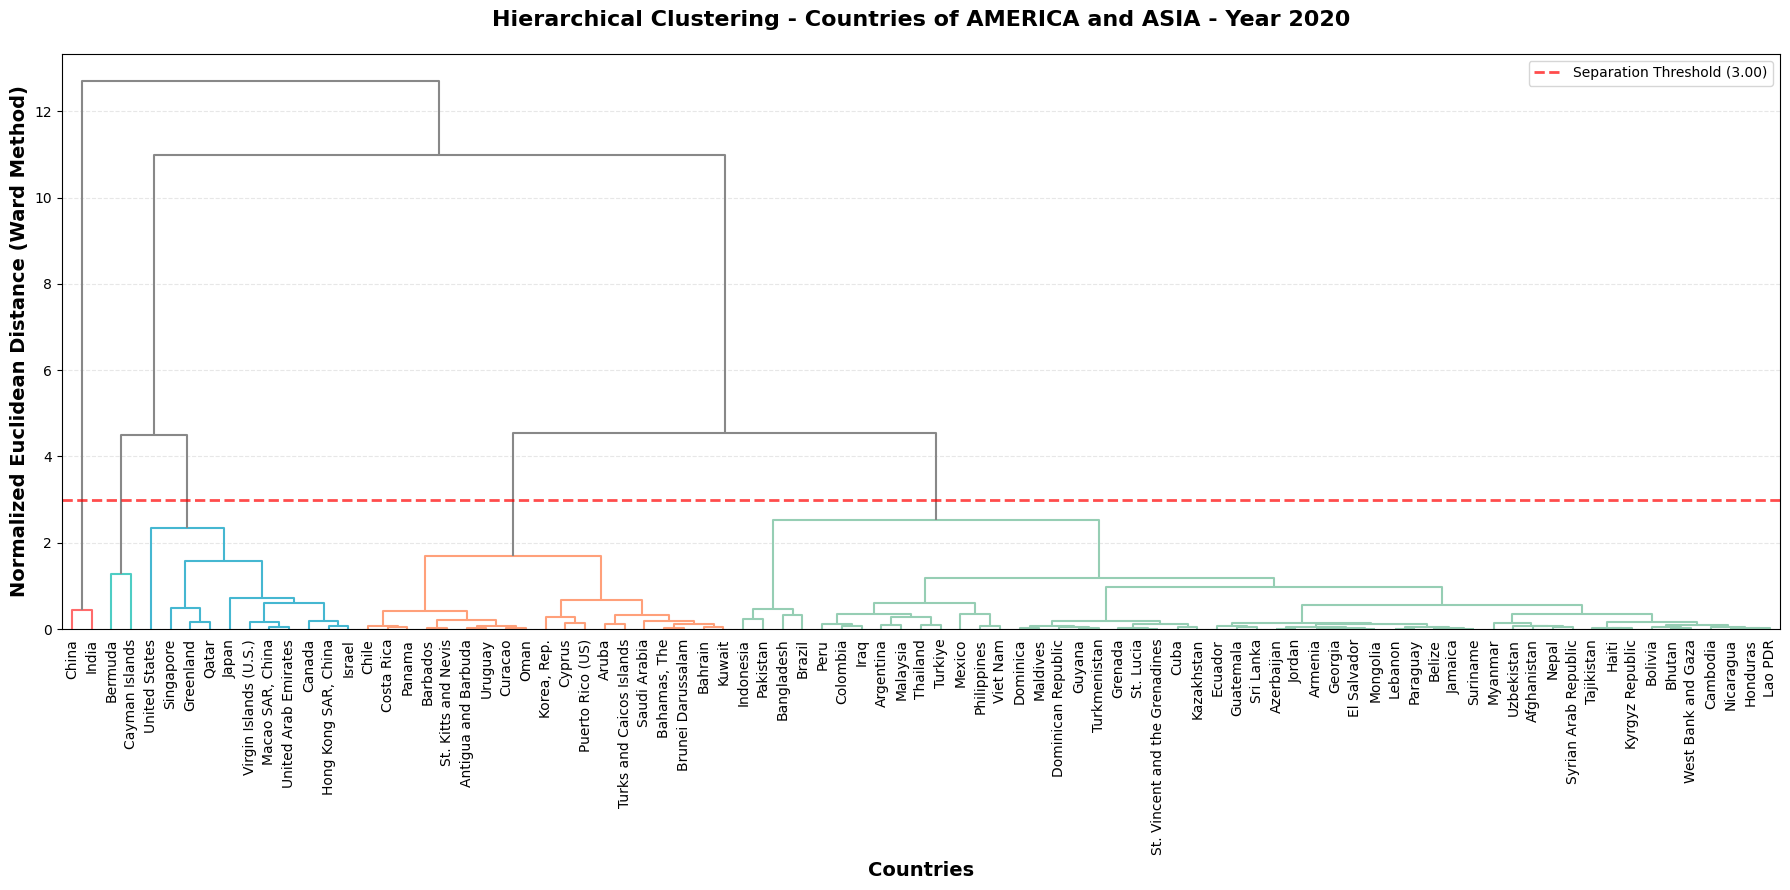

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2020.
With a Distance Threshold of 3.00, 5 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (2 countries): Cayman Islands, Bermuda
Cluster 3 (11 countries): Greenland, Japan, Hong Kong SAR, China, Canada, Israel, Macao SAR, China, Singapore, Virgin Islands (U.S.), United Arab Emirates, United States, Qatar
Cluster 4 (19 countries): Cyprus, Korea, Rep., Oman, Kuwait, Costa Rica, Barbados, Brunei Darussalam, Aruba, Panama, Puerto Rico (US), Saudi Arabia, St. Kitts and Nevis, Curacao, Chile, Antigua and Barbuda, Bahamas, The, Bahrain, Turks and Caicos I

In [ ]:
Target_Year = '2020'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year_filtered = df_america_asia[df_america_asia['Year'] == Target_Year].copy()

df_year_filtered.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year_filtered)} countries...")


# Prepare data
features_for_clustering = df_year_filtered[['Population', 'GDP_per_capita']].values
country_names = df_year_filtered['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering - Countries of AMERICA and ASIA - Year {Target_Year}',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year_filtered['Cluster'] = clusters
df_year_filtered.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year_filtered.loc[df_year_filtered['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

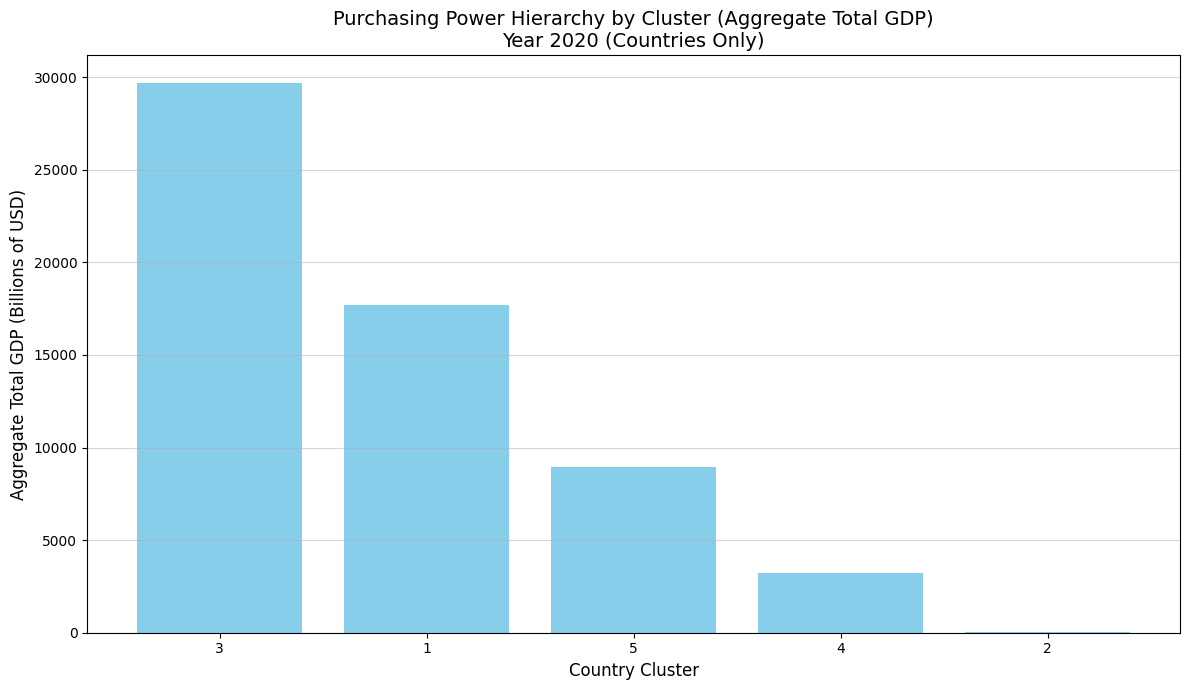

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year_filtered.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

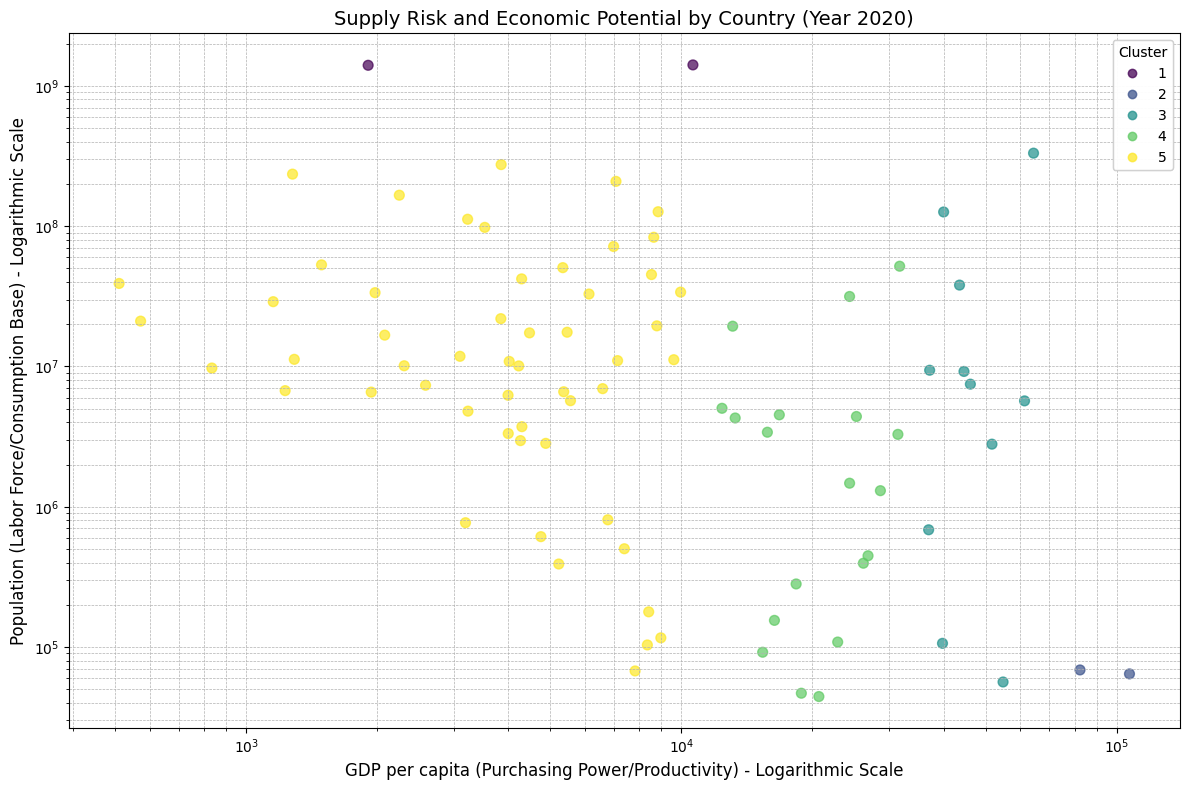

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year_filtered.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2021

Calculating hierarchical clustering for the year 2021 with 87 countries...


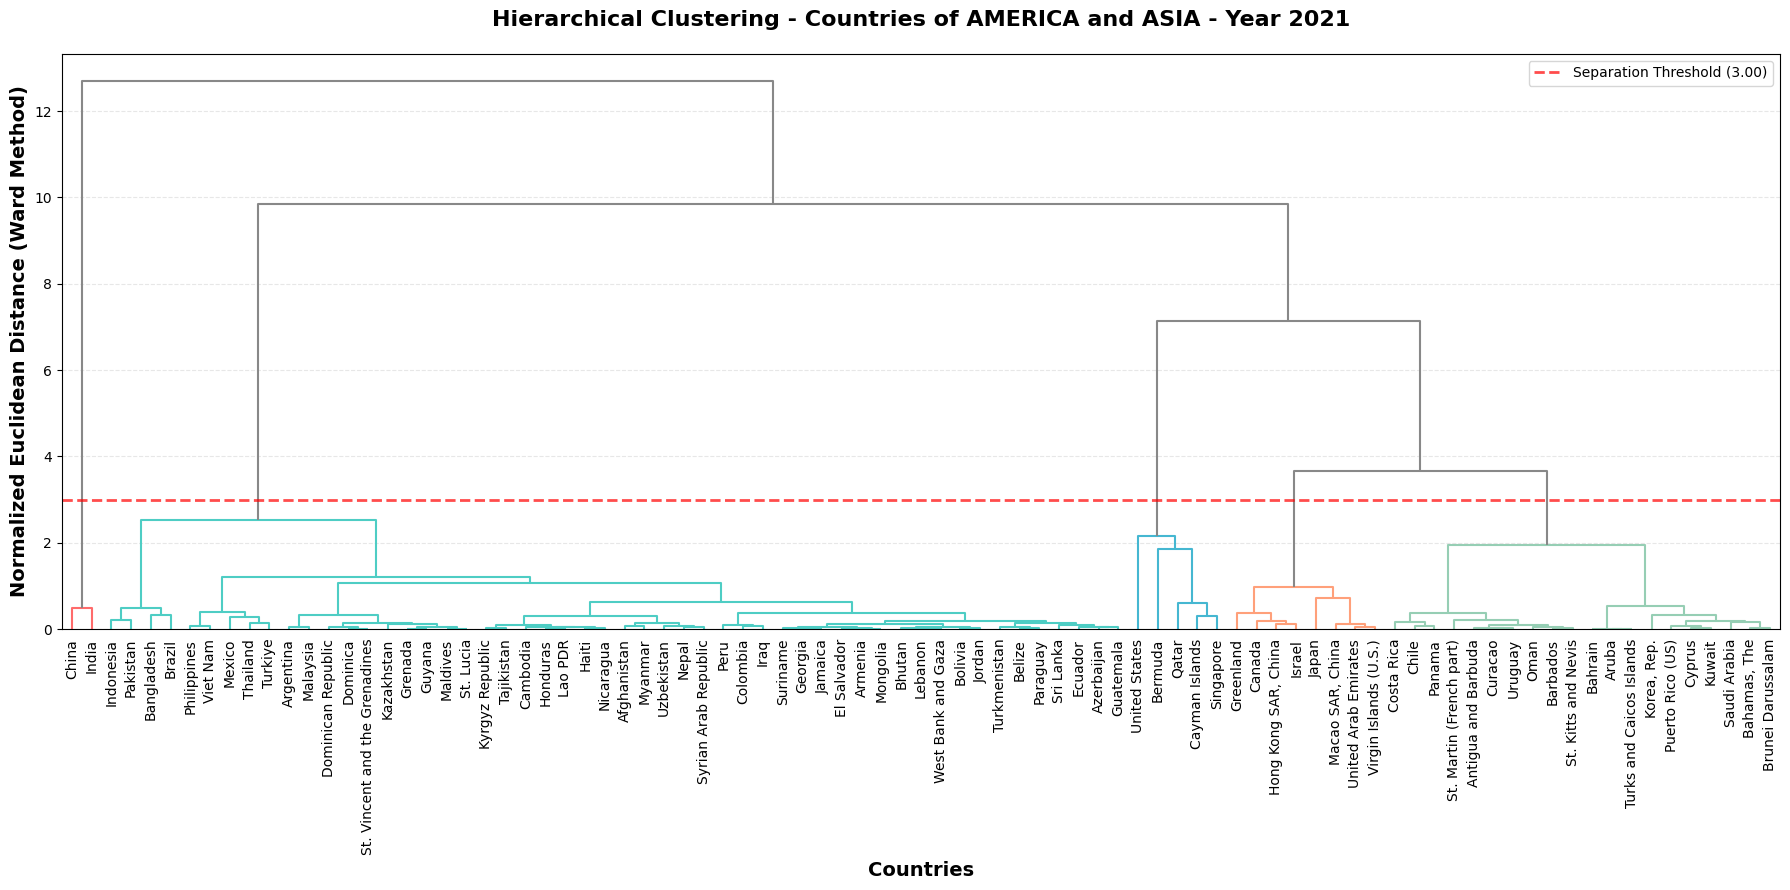

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2021.
With a Distance Threshold of 3.00, 5 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (52 countries): Armenia, Afghanistan, Bhutan, Bolivia, Belize, Argentina, Brazil, Dominican Republic, Ecuador, El Salvador, Grenada, Colombia, Cambodia, Azerbaijan, Georgia, Dominica, Malaysia, Maldives, Mongolia, Kazakhstan, Jordan, Kyrgyz Republic, Jamaica, Iraq, Indonesia, Honduras, Guyana, Haiti, Guatemala, Bangladesh, Philippines, Nicaragua, Pakistan, Paraguay, Peru, Mexico, Myanmar, Nepal, Lebanon, Lao PDR, Syrian Arab Republic, Tajikistan, Thailand, Tur

In [ ]:
Target_Year = '2021'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year_filtered = df_america_asia[df_america_asia['Year'] == Target_Year].copy()

df_year_filtered.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year_filtered)} countries...")


# Prepare data
features_for_clustering = df_year_filtered[['Population', 'GDP_per_capita']].values
country_names = df_year_filtered['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering - Countries of AMERICA and ASIA - Year {Target_Year}',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year_filtered['Cluster'] = clusters
df_year_filtered.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year_filtered.loc[df_year_filtered['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

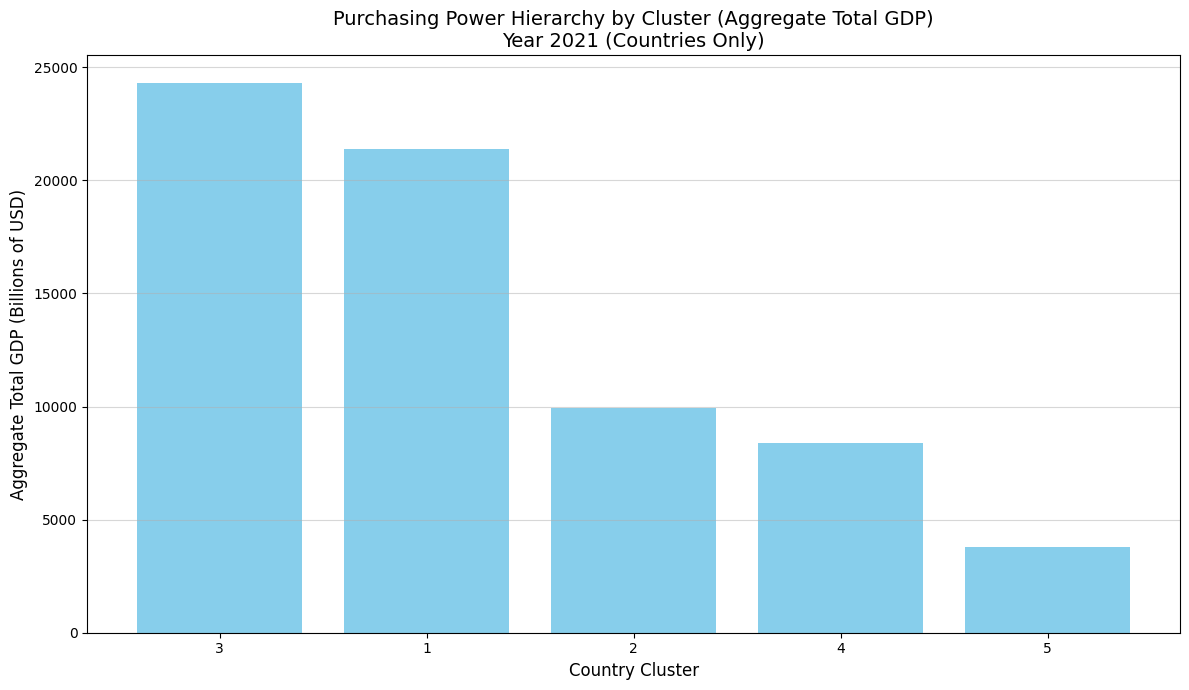

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year_filtered.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

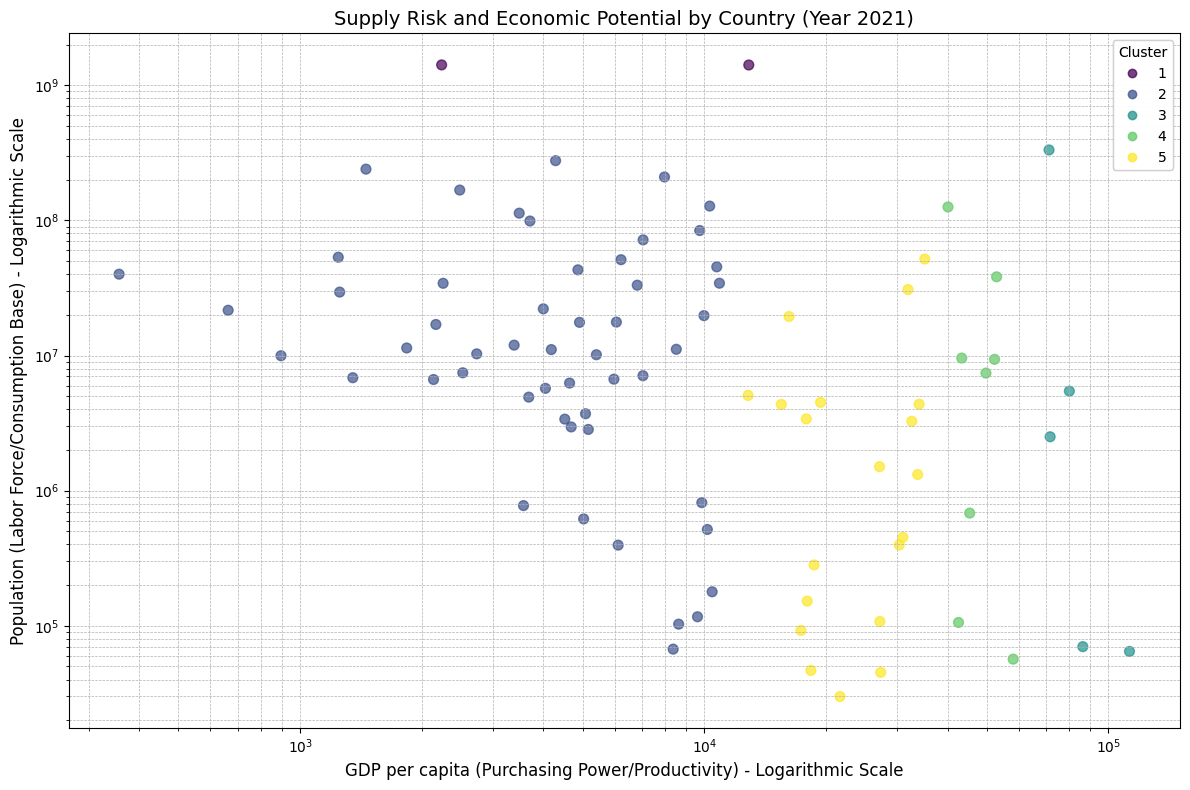

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year_filtered.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2022

Calculating hierarchical clustering for the year 2022 with 86 countries...


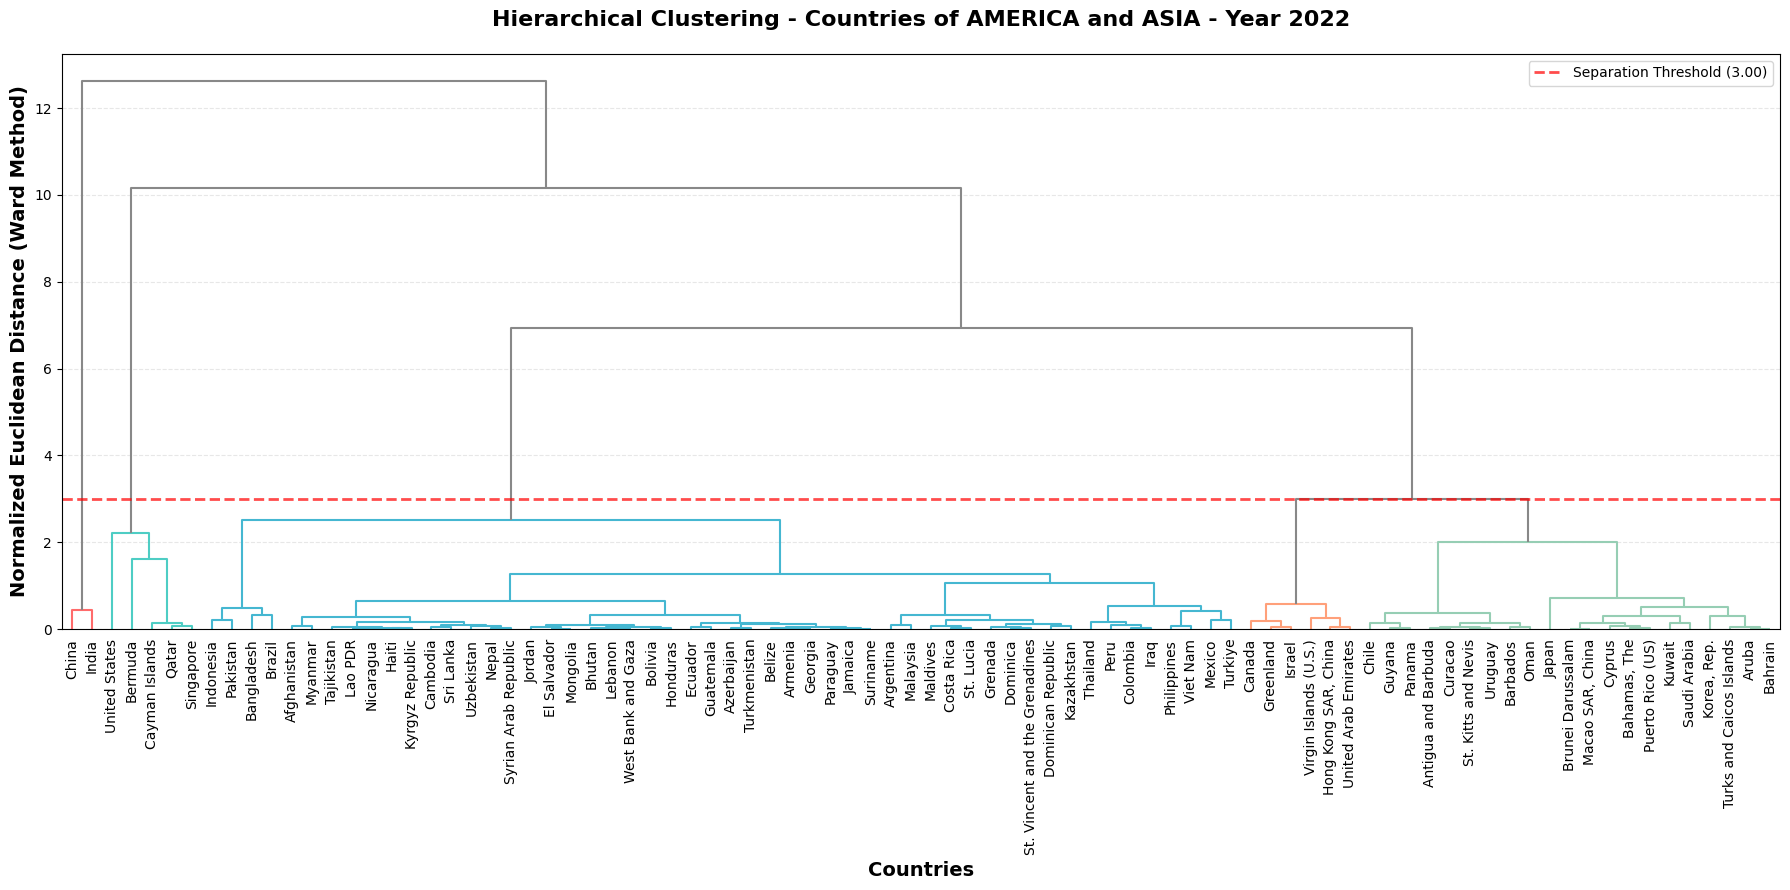

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2022.
With a Distance Threshold of 3.00, 5 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (5 countries): Cayman Islands, Bermuda, Singapore, United States, Qatar
Cluster 3 (52 countries): Bhutan, Brazil, Bolivia, Ecuador, Costa Rica, Cambodia, Belize, Armenia, Afghanistan, Grenada, Georgia, El Salvador, Dominica, Dominican Republic, Mexico, Kazakhstan, Kyrgyz Republic, Jamaica, Jordan, Indonesia, Iraq, Haiti, Colombia, Bangladesh, Argentina, Philippines, Nicaragua, Pakistan, Paraguay, Peru, Nepal, Myanmar, Lao PDR, Maldives, Malaysia, Lebanon, Mong

In [ ]:
Target_Year = '2022'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year_filtered = df_america_asia[df_america_asia['Year'] == Target_Year].copy()

df_year_filtered.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year_filtered)} countries...")


# Prepare data
features_for_clustering = df_year_filtered[['Population', 'GDP_per_capita']].values
country_names = df_year_filtered['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering - Countries of AMERICA and ASIA - Year {Target_Year}',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year_filtered['Cluster'] = clusters
df_year_filtered.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year_filtered.loc[df_year_filtered['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

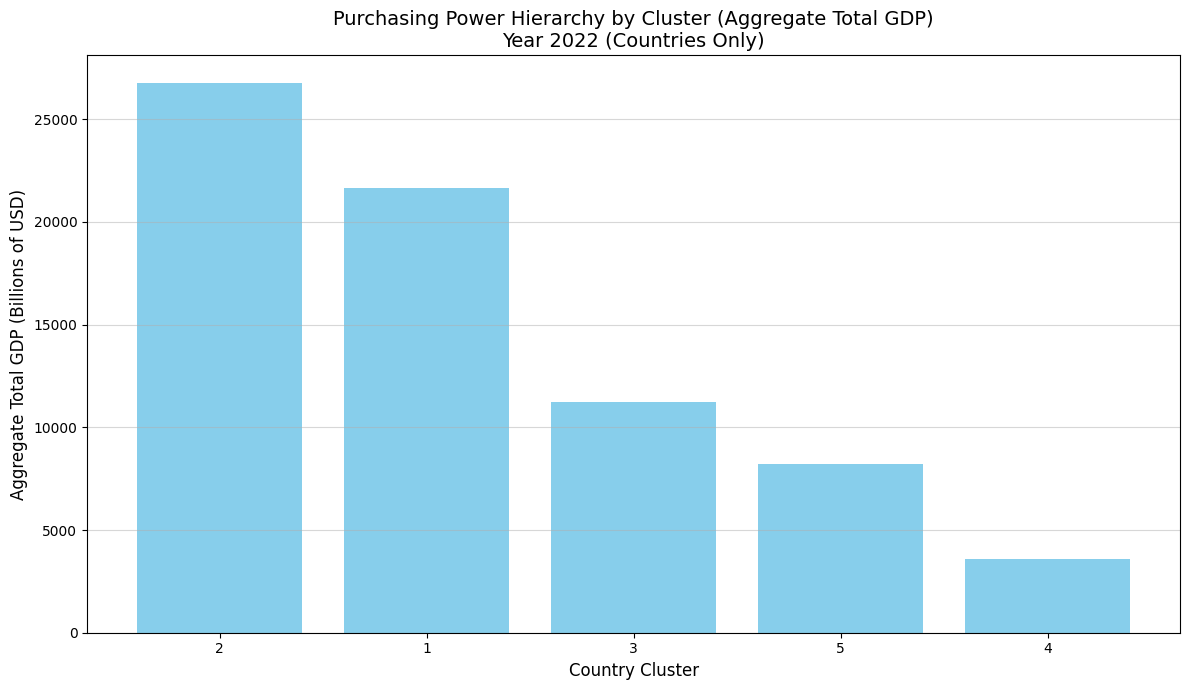

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year_filtered.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

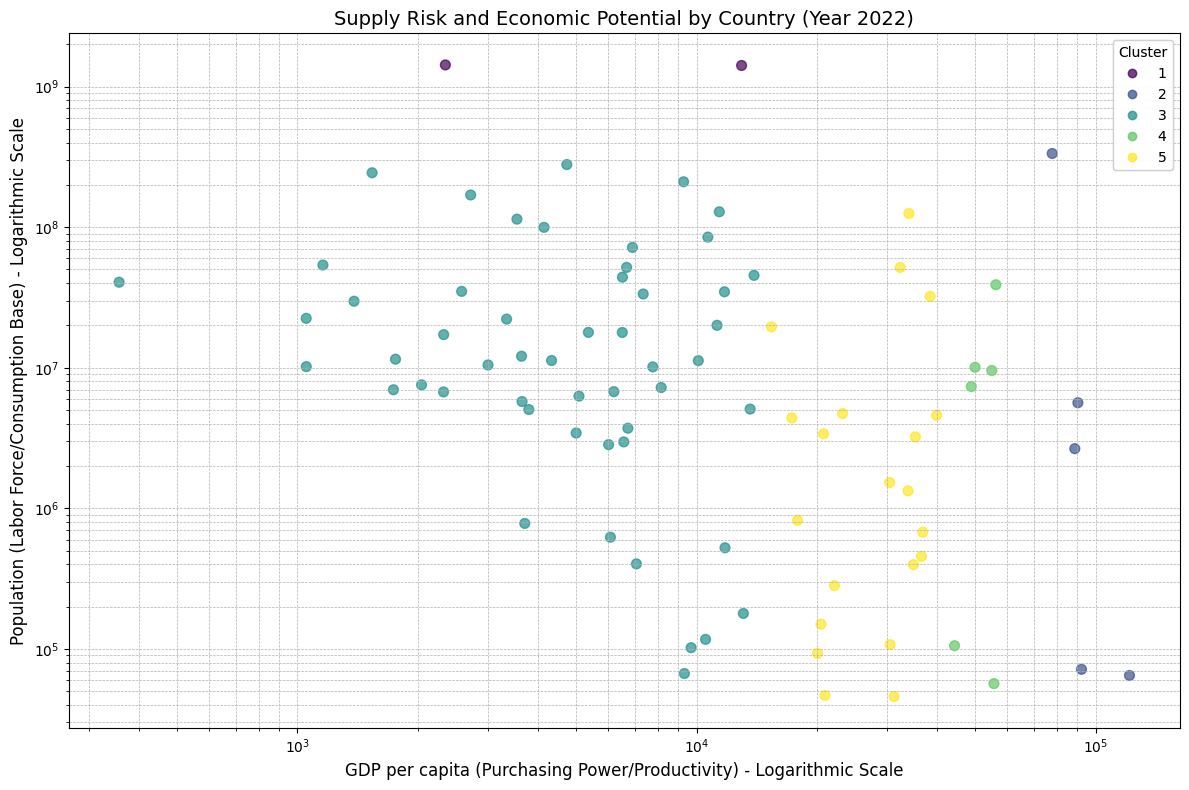

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year_filtered.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2023

Calculating hierarchical clustering for the year 2023 with 85 countries...


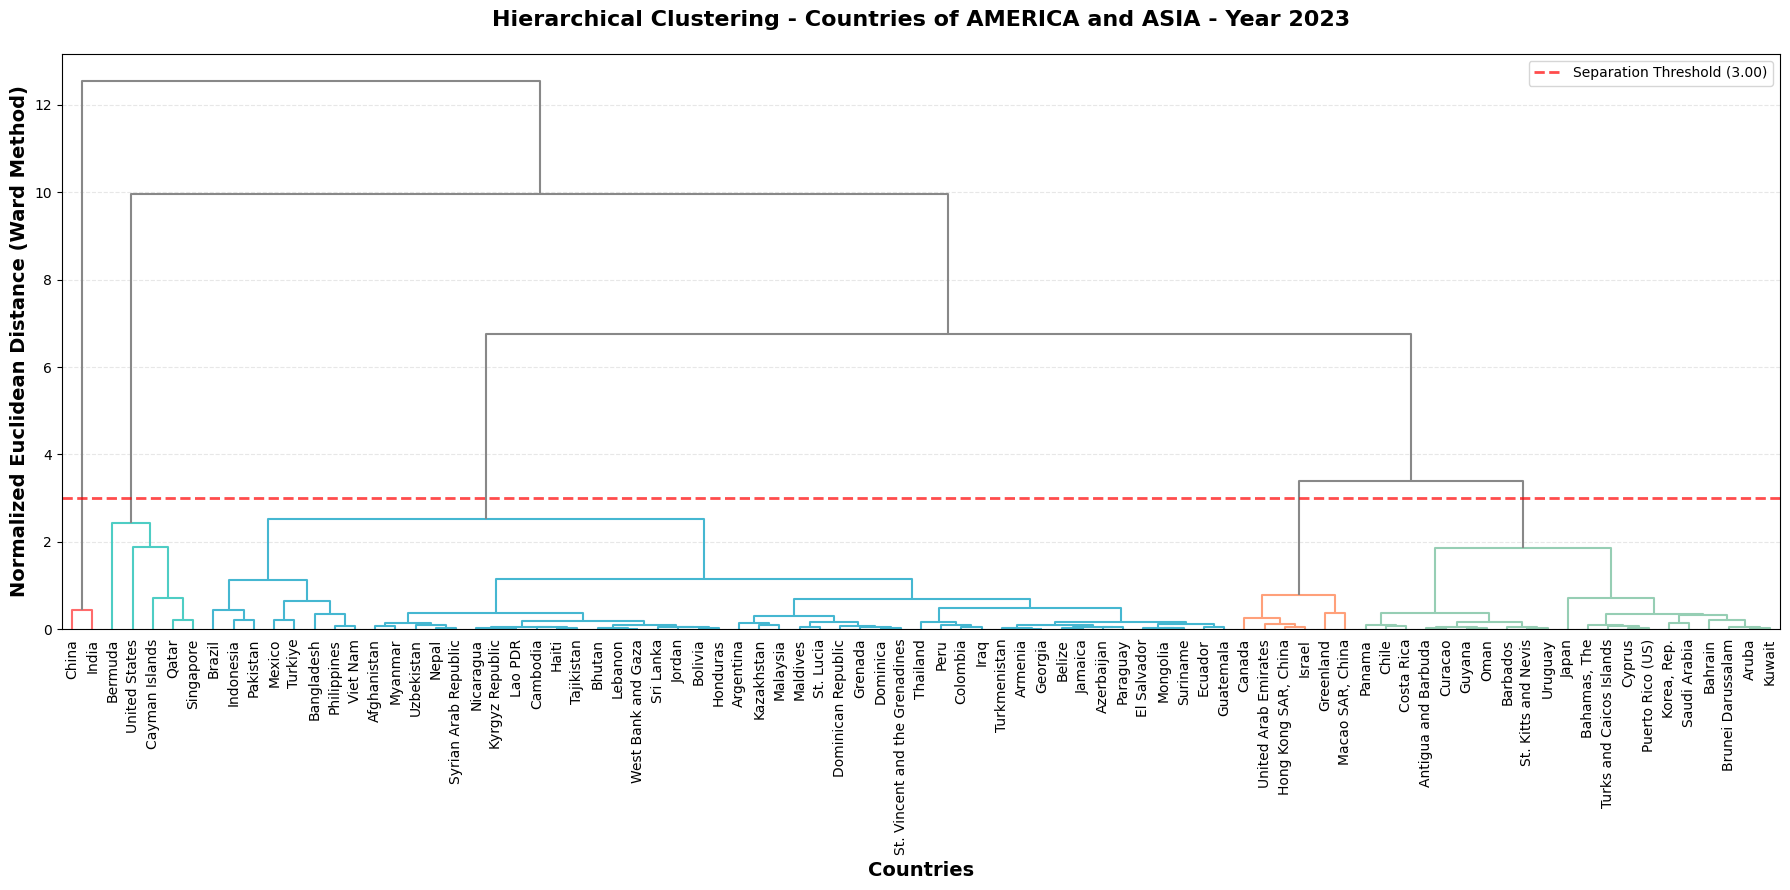

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2023.
With a Distance Threshold of 3.00, 5 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): China, India
Cluster 2 (5 countries): Cayman Islands, Bermuda, Singapore, United States, Qatar
Cluster 3 (51 countries): Bhutan, Brazil, Bolivia, Ecuador, El Salvador, Cambodia, Belize, Armenia, Afghanistan, Grenada, Georgia, Dominican Republic, Dominica, Mongolia, Mexico, Kazakhstan, Kyrgyz Republic, Jamaica, Jordan, Indonesia, Iraq, Haiti, Colombia, Bangladesh, Argentina, Philippines, Nicaragua, Pakistan, Paraguay, Peru, Nepal, Myanmar, Lao PDR, Maldives, Malaysia, Lebanon, St. Vi

In [ ]:
Target_Year = '2023'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year_filtered = df_america_asia[df_america_asia['Year'] == Target_Year].copy()

df_year_filtered.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year_filtered)} countries...")


# Prepare data
features_for_clustering = df_year_filtered[['Population', 'GDP_per_capita']].values
country_names = df_year_filtered['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering - Countries of AMERICA and ASIA - Year {Target_Year}',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year_filtered['Cluster'] = clusters
df_year_filtered.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year_filtered.loc[df_year_filtered['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

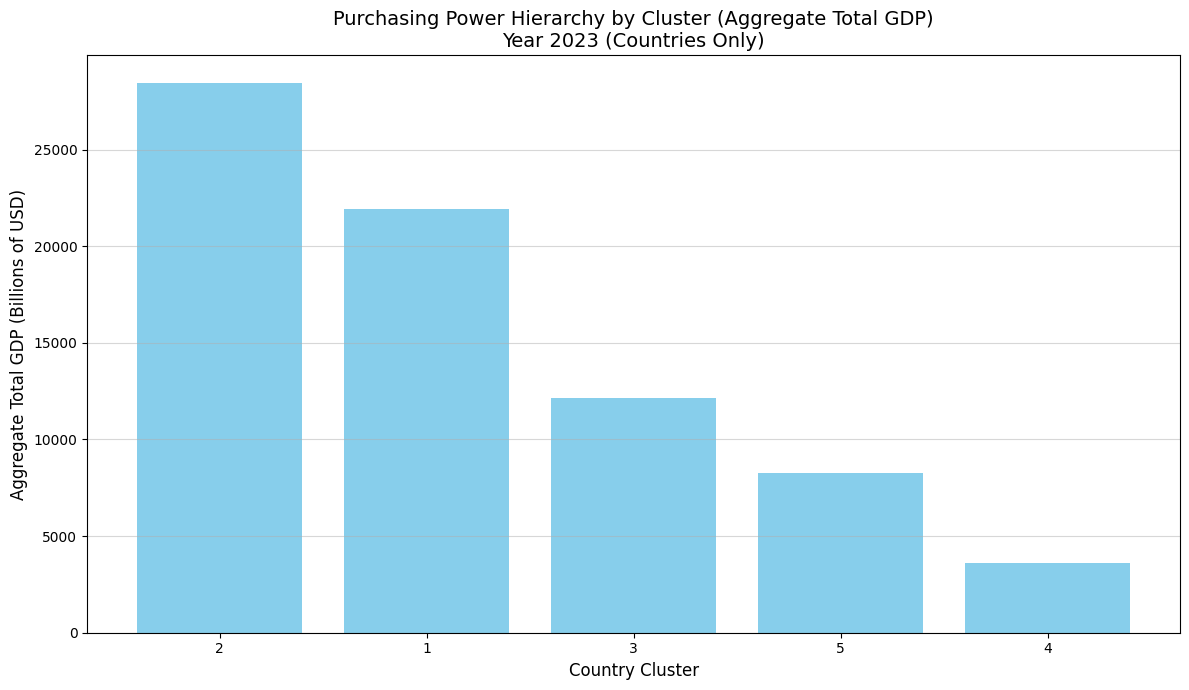

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year_filtered.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

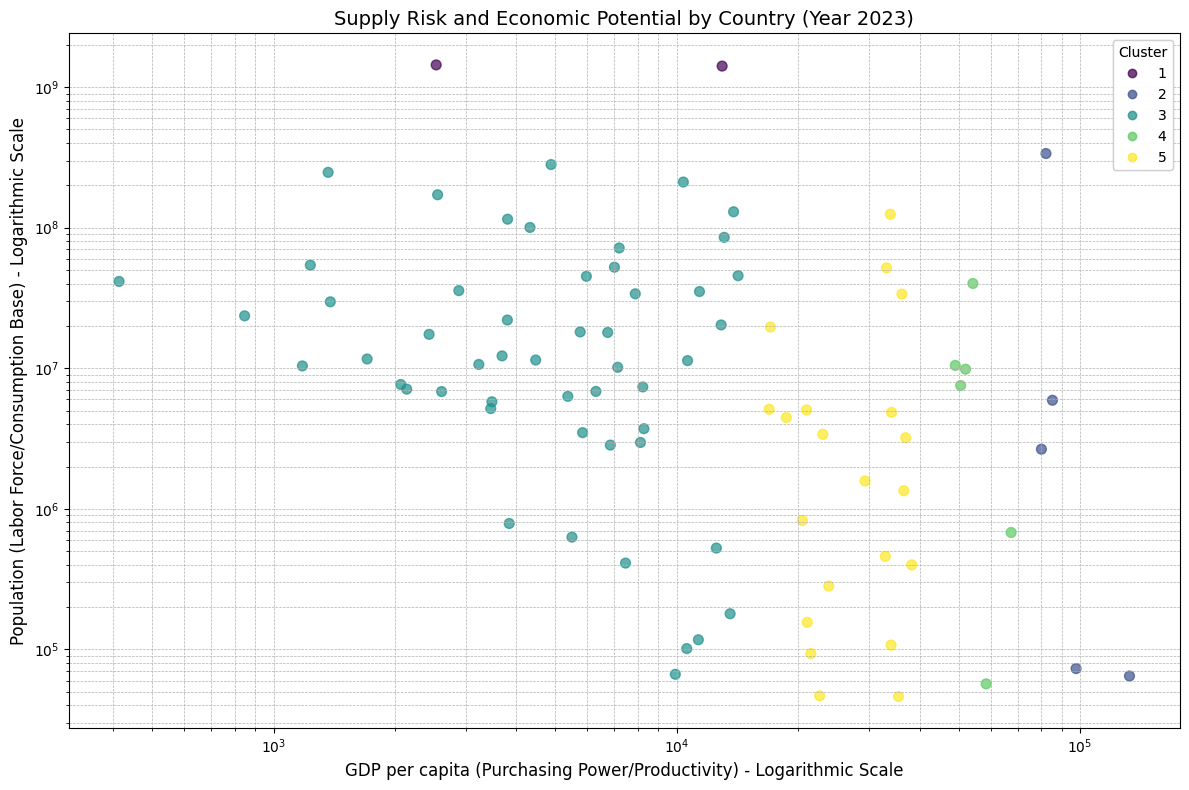

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year_filtered.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()

## 2024

Calculating hierarchical clustering for the year 2024 with 76 countries...


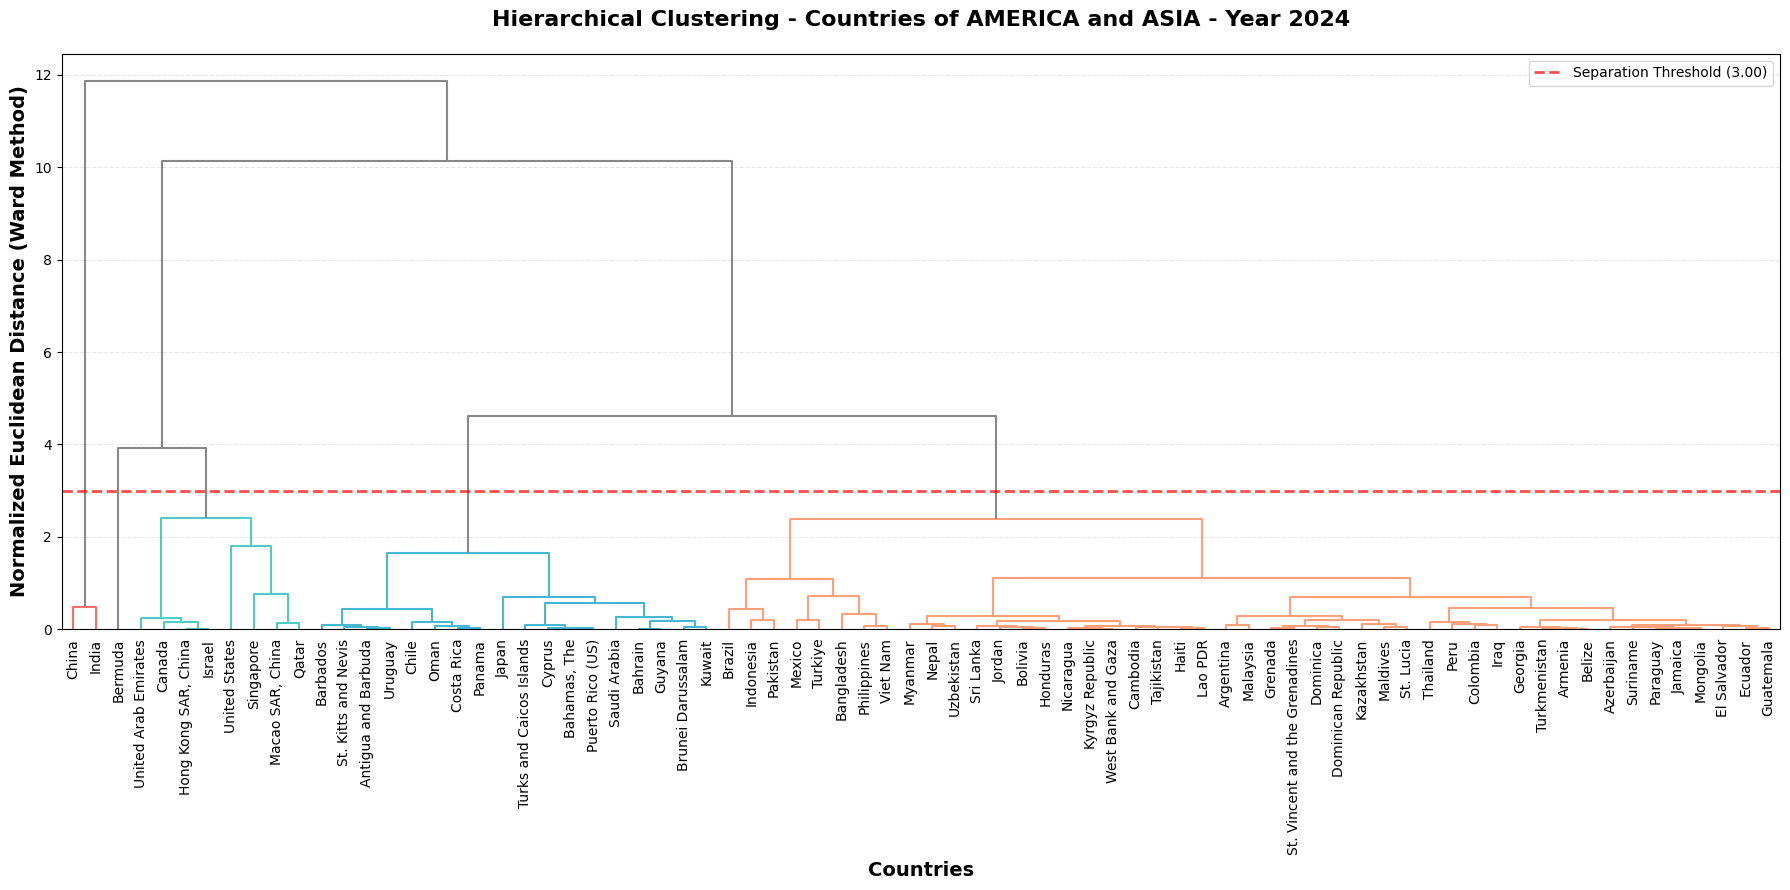

----------------------------------------------------------------------------------
Interpretation:
The dendrogram shows the grouping of countries based on their Population and GDP per capita data in 2024.
With a Distance Threshold of 3.00, 5 distinct clusters were formed.
- Nearby countries have similar characteristics
- The height indicates the distance between clusters
- Each color represents a different cluster
- The red line marks the separation threshold

Countries per Cluster:
Cluster 1 (2 countries): India, China
Cluster 2 (8 countries): Canada, Hong Kong SAR, China, Singapore, Qatar, Macao SAR, China, Israel, United States, United Arab Emirates
Cluster 3 (1 countries): Bermuda
Cluster 4 (18 countries): Brunei Darussalam, Costa Rica, Chile, Guyana, Cyprus, Japan, Kuwait, Oman, Panama, Bahrain, Saudi Arabia, St. Kitts and Nevis, Puerto Rico (US), Bahamas, The, Turks and Caicos Islands, Antigua and Barbuda, Barbados, Uruguay
Cluster 5 (47 countries): Cambodia, Bolivia, Brazil, Hai

In [ ]:
Target_Year = '2024'

# Define the distance threshold. ADJUST THIS VALUE to change the number of clusters.
# A lower value creates more clusters
my_threshold = 3.0

df_year_filtered = df_america_asia[df_america_asia['Year'] == Target_Year].copy()

df_year_filtered.dropna(subset=['Population', 'GDP_per_capita'], inplace=True)

print(f"Calculating hierarchical clustering for the year {Target_Year} with {len(df_year_filtered)} countries...")


# Prepare data
features_for_clustering = df_year_filtered[['Population', 'GDP_per_capita']].values
country_names = df_year_filtered['Country_Name'].values

# Normalize data (CRUCIAL)
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_for_clustering)

# 1. Calculate distance matrix (Intermediate step, optional with 'linkage')
distances = pdist(features_normalized, metric='euclidean')

# 2. Calculate linkage matrix (Ward minimizes within-cluster variance)
linkage_matrix = linkage(distances, method='ward')

fig, ax = plt.subplots(figsize=(18, 9))

# Configure a color palette for the clusters
from scipy.cluster.hierarchy import set_link_color_palette
# Palette inspired by the colors you used
set_link_color_palette(['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4', '#F7DC6F', '#70A1FF'])

# Create dendrogram
dendro = dendrogram(linkage_matrix,
                     labels=country_names,
                     leaf_font_size=10,
                     color_threshold=my_threshold,  # The cut height for the color
                     above_threshold_color='#888888', # Color of branches above the threshold
                     ax=ax)

# --- Chart Styles ---
plt.title(f'Hierarchical Clustering - Countries of AMERICA and ASIA - Year {Target_Year}',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Countries', fontsize=14, weight='bold')
plt.ylabel('Normalized Euclidean Distance (Ward Method)', fontsize=14, weight='bold')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add horizontal threshold line
plt.axhline(y=my_threshold, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Separation Threshold ({my_threshold:.2f})')
plt.legend()

plt.tight_layout()
plt.show()


# Use fcluster to assign each country to its cluster, based on the same threshold
clusters = fcluster(linkage_matrix, t=my_threshold, criterion='distance')
n_clusters = len(np.unique(clusters))

print("----------------------------------------------------------------------------------")
print("Interpretation:")
print(f"The dendrogram shows the grouping of countries based on their Population and GDP per capita data in {Target_Year}.")
print(f"With a Distance Threshold of {my_threshold:.2f}, {n_clusters} distinct clusters were formed.")
print("- Nearby countries have similar characteristics")
print("- The height indicates the distance between clusters")
print("- Each color represents a different cluster")
print("- The red line marks the separation threshold")

print("\nCountries per Cluster:")
df_year_filtered['Cluster'] = clusters
df_year_filtered.sort_values(by='Cluster', inplace=True)

# Map countries to the DataFrame to display
for i in range(1, n_clusters + 1):
    countries_in_cluster = df_year_filtered.loc[df_year_filtered['Cluster'] == i, 'Country_Name'].values
    print(f"Cluster {i} ({len(countries_in_cluster)} countries): {', '.join(countries_in_cluster)}")
print("----------------------------------------------------------------------------------")

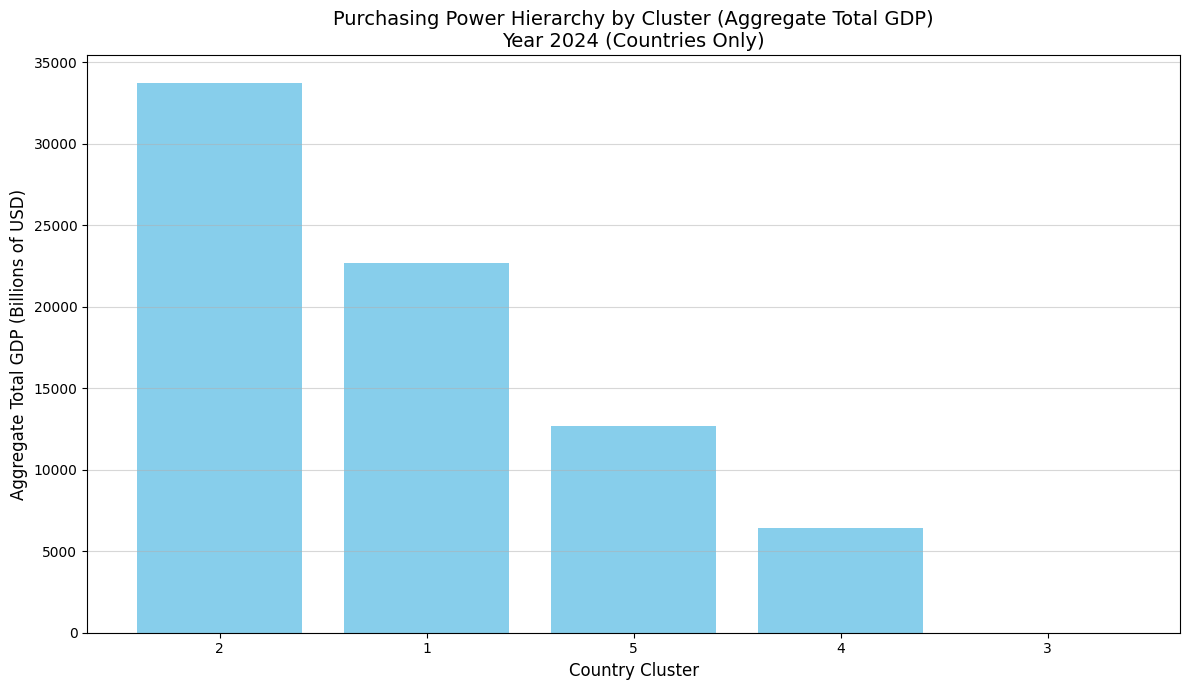

In [ ]:
# A. CALCULATION AND GROUPING
df_analysis = df_year_filtered.copy()

# 1. Calculate Total GDP (Aggregate Purchasing Power)
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# 2. Group by Cluster and sum Total GDP
cluster_gdp_hierarchy = df_analysis.groupby('Cluster')['Total_GDP'].sum().sort_values(ascending=False).reset_index()

# 3. Convert to billions of USD for better readability
cluster_gdp_hierarchy['Total_GDP_Billion'] = cluster_gdp_hierarchy['Total_GDP'] / 1_000_000_000

# B. GENERATION OF THE BAR CHART
plt.figure(figsize=(12, 7))
plt.bar(
    cluster_gdp_hierarchy['Cluster'].astype(str),
    cluster_gdp_hierarchy['Total_GDP_Billion'],
    color='skyblue'
)

plt.title(f'Purchasing Power Hierarchy by Cluster (Aggregate Total GDP)\nYear {Target_Year} (Countries Only)', fontsize=14)
plt.xlabel('Country Cluster', fontsize=12)
plt.ylabel('Aggregate Total GDP (Billions of USD)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

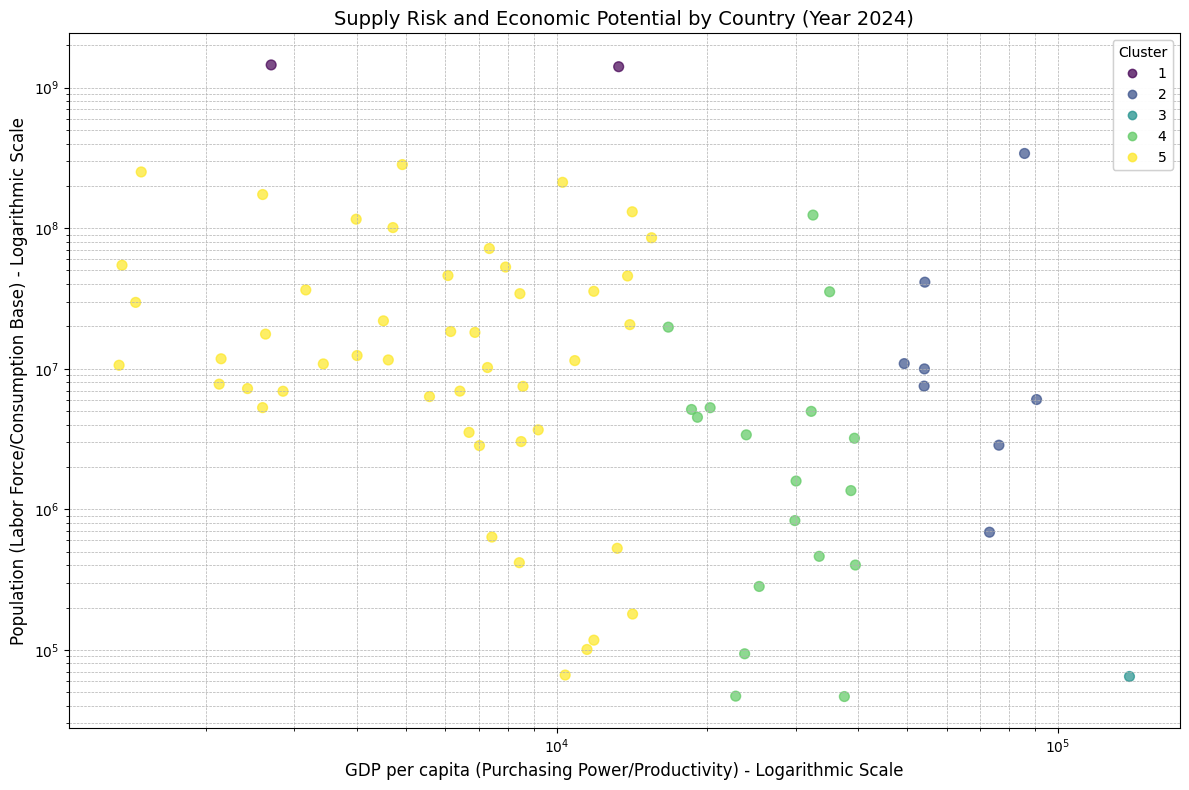

In [ ]:
# df_year (clean and with clusters) is the one we will use
df_analysis = df_year_filtered.copy()

# The calculation of Total_GDP is not strictly necessary for the scatter plot,
# but it is good for reference if you have it:
df_analysis['Total_GDP'] = df_analysis['Population'] * df_analysis['GDP_per_capita']

# ============================================================================
# CORRECTED SCATTER PLOT CODE
# ============================================================================
plt.figure(figsize=(12, 8))

# Color the points according to the cluster they belong to
scatter = plt.scatter(
    df_analysis['GDP_per_capita'],
    df_analysis['Population'],
    c=df_analysis['Cluster'], # Now it only has countries!
    cmap='viridis',
    alpha=0.7,
    s=50
)

# Configure Axes on Logarithmic Scale (CRUCIAL)
plt.xscale('log')
plt.yscale('log')

plt.title('Supply Risk and Economic Potential by Country (Year ' + df_analysis['Year'].iloc[0] + ')', fontsize=14)
plt.xlabel('GDP per capita (Purchasing Power/Productivity) - Logarithmic Scale', fontsize=12)
plt.ylabel('Population (Labor Force/Consumption Base) - Logarithmic Scale', fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Add cluster legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)

plt.tight_layout()
plt.show()